# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import shap
import bisect
import warnings

import numpy             as np
import pandas            as pd
import scipy.stats       as stats

import seaborn           as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec     import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn.combine        import SMOTETomek

from sklearn.metrics         import roc_auc_score, recall_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier

from boruta                  import BorutaPy

from skopt                   import forest_minimize
from skopt.plots             import plot_convergence

#from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve


# costomized packages
import sys
sys.path.append('../')

from src.data.make_dataset   import Dataset

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('seaborn-bright')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#============================================ Statistical Summary ============================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(stats.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T
    iqr = pd.DataFrame(q75.reset_index(drop=True) - q25.reset_index(drop=True))

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = q25.reset_index(drop=True) - 1.5 * iqr.reset_index(drop=True)
    high_outliers = q75.reset_index(drop=True) + 1.5 * iqr.reset_index(drop=True)


    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q25, q75, q95, iqr, low_outliers, high_outliers, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '25%', '75%', '95%','IQR', 'Low Outliers', 'High Outliers', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



#========================================= Group Age by an Age Stage =========================================#
def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



#========================================== Cramer V (Correlation) ===========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



#========================================== Categorical Correlation ==========================================#
def categorical_correlation(df):
    cat_attributes_list = df.columns.tolist()
    
    corr_dict = {}
    for i in range(len(cat_attributes_list)):
        corr_list = []
        for j in range(len(cat_attributes_list)):
            ref = cat_attributes_list[i]
            feat = cat_attributes_list[j]

            # correlation
            corr = cramer_v(df[ref], df[feat])

            # append list
            corr_list.append(corr)

        # append correlation list for each ref attributes  
        corr_dict[ref] = corr_list

    d = pd.DataFrame(corr_dict)
    d = d.set_index(d.columns)
    
    return d



#============================================== Cumulative Gain ==============================================#
def df_cumulative_gain(y_true, yhat_proba):
    results = pd.DataFrame()
    results['prediction'] = yhat_proba[:,1].tolist()
    results['real'] = y_true.tolist()

    # ordering by prediction
    results = results.sort_values('prediction', ascending=False)

    # Percentage of intereset ( Propensity Score )
    results['real_cum'] = results['real'].cumsum() 
    results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

    # Percentage of Base ( Clients )
    results['ranking'] = range(1, len(results) + 1)
    results['base_cum_perc'] = 100*results['ranking']/len(results)

    # Basline model
    results['baseline'] = results['base_cum_perc']
    
    # Lift Calculation
    results['lift'] = results['real_cum_perc'] / results['base_cum_perc']
    
    # precision_at_k
    results['precision_at_k'] = results['real_cum'] / results['ranking']
    
    # recall_at_k
    results['recall_at_k'] = results['real_cum'] / results['real'].sum()
    
    return results



#========================================== Machine Learning Scores ==========================================#
def ml_scores(model_name, y_true, yhat_proba, top_k, k):
    
    #roc_auc = roc_auc_score(y_true, yhat_proba[:,1])
    
    results = df_cumulative_gain(y_true, yhat_proba)
    results_score = results.reset_index().rename(columns={'index': 'real_index'})
    
    top_k_scores = dict()
    if isinstance(top_k, list): 
        for j in top_k:
            accuracy_top_k = results_score.loc[round(j*len(results_score)), 'real_cum_perc']
            top_k_scores[f'accuracy_top_{100*j}%'] = accuracy_top_k
        df_top_k_score = pd.DataFrame(top_k_scores, index=[0])
    else:
        accuracy_top_k = results_score.loc[round(top_k*len(results_score)), 'real_cum_perc']
        top_k_scores[f'accuracy_top_{100*top_k}%'] = accuracy_top_k
        df_top_k_score = pd.DataFrame(top_k_scores, index=[0])
    
    # Model Name
    score = pd.DataFrame({ 'model_name': model_name}, index=[0])
    # precision_at_k    
    precision_at_k = results_score.loc[k, 'precision_at_k']

    # recall_at_k
    recall_at_k = results_score.loc[k, 'recall_at_k']


    dict_prec_recall_at_k = { 'precision_at_k': precision_at_k,
                              'recall_at_k'   : recall_at_k}

    df_precision_recall_at_k = pd.DataFrame(dict_prec_recall_at_k, index=[0])
    
     
    return pd.concat([score, df_top_k_score, df_precision_recall_at_k], axis=1), results



#===================================== Machine Learning Cross Validation =====================================#
def cross_validation(X_train, y_train, model, top_k, k, num_folds=5, is_unbalance=False, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)   

    # Empty Structure for Score
    score_dict = dict()
    if isinstance(top_k, list):
        for j in top_k:
            score_dict[f'accuracy_top_{100*j}%'] = []
    else:
        score_dict[f'accuracy_top_{100*top_k}%'] = []
    #score_dict['roc_auc_acc'] = []
    score_dict['precision_at_k'] = []
    score_dict['recall_at_k'] = []
    
    # Model Name
    model_name = type(model).__name__

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
            
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        # balance
        if is_unbalance:
            # ratio balanced
            ratio_balanced = y_train.value_counts().to_dict()
            ratio_balanced[1] = round(ratio_balanced[0]/ratio_balanced[1]) * ratio_balanced[1]
            # define sampler
            smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)
            
            # apply sampler
            X_train_fold, y_train_fold = smt.fit_resample(X_train_fold, y_train_fold)
            
        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat_proba = model.predict_proba(X_val_fold)

        
        # metrics
        model_result, _ = ml_scores(model_name, y_val_fold, yhat_proba, top_k, k)
        
        #Store Performance of each KFold iteration
        for key in score_dict.keys():
            score_dict[key].append(model_result[key].tolist())
        
        i += 1
    
    dict_result = {'model_name': model_name}
    for key in score_dict.keys():
        dict_result[key] = np.round(np.mean(score_dict[key]),4).astype(str) + ' +/- ' + np.round(np.std(score_dict[key]),4).astype(str)
        
    return pd.DataFrame(dict_result, index=[0])

## 0.3 Loading data

In [5]:
dataset = Dataset()

### 0.3.1 Saving Test Dataset

In [6]:
#dataset.get_test_data('../zip')

### 0.3.2 Query Train Dataset

In [7]:
df_raw = dataset.get_train_data("../query/raw_data.sql")

### 0.3.3 Saving the Data

In [8]:
#Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
# train_dataset.to_feather('../data/interim/training_data.feather')
# test_dataset.to_feather('../data/interim/test_data.feather')

### 0.3.4 Read Training Dataset

In [9]:
df_train = pd.read_feather('../data/interim/training_data.feather')

# 1.0 Data Description

In [10]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,217244,Female,41,47.0,152.0,1,1-2 Year,No,1,2630.0,34,0
1,62034,Female,23,36.0,152.0,1,< 1 Year,No,1,34188.0,30,0
2,290598,Male,71,28.0,26.0,1,1-2 Year,Yes,0,52749.0,91,0
3,213946,Male,43,26.0,124.0,1,1-2 Year,Yes,0,25326.0,230,0
4,209186,Male,58,8.0,124.0,1,1-2 Year,No,1,2630.0,116,0


## 1.1 Data Dimensions

In [11]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 323942
Number of Columns: 12


## 1.2 Data Type

In [12]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [13]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 ~~Change Data type~~

## 1.5 Check Balanced Data

In [14]:
df01['response'].value_counts(normalize=True)

0    0.877438
1    0.122562
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [15]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [16]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,25%,75%,95%,IQR,Low Outliers,High Outliers,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.826274,36.0,21.0,25.0,49.0,69.0,24.0,-11.0,85.0,15.517508,0.399665,0.673293,-0.565892
1,region_code,0.0,52.0,52.0,28.0,26.393033,28.0,5.0,15.0,35.0,47.0,20.0,-15.0,65.0,13.228600,0.501216,-0.115215,-0.867152
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.020346,132.0,26.0,29.0,152.0,160.0,123.0,-155.5,336.5,54.211038,0.483939,-0.899422,-0.971961
3,driving_license,0.0,1.0,1.0,1.0,0.997898,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.045802,0.045898,-21.741487,470.695147
4,previously_insured,0.0,1.0,1.0,0.0,0.457983,0.0,0.0,0.0,1.0,1.0,1.0,-1.5,2.5,0.498231,1.087881,0.168664,-1.971564
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30544.875234,31667.0,2630.0,24380.0,39406.0,55139.0,15026.0,1841.0,61945.0,17206.737636,0.563326,1.765382,34.531512
6,vintage,10.0,299.0,289.0,73.0,154.375379,154.0,24.0,82.0,227.0,285.0,145.0,-135.5,444.5,83.647592,0.541845,0.002887,-1.199693
7,response,0.0,1.0,1.0,0.0,0.122562,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.327934,2.675655,2.301926,3.298883


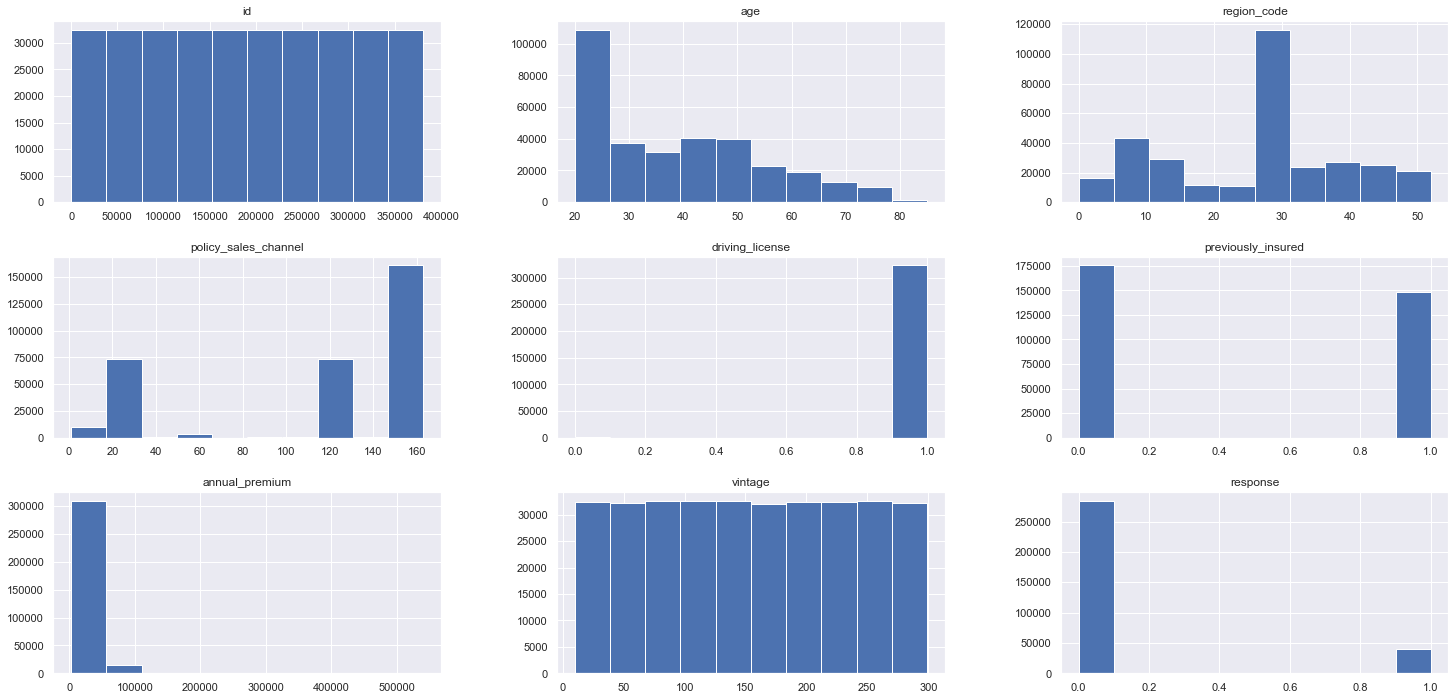

In [17]:
num_attributes.hist();

### 1.6.2 Categorical Attributes

In [18]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,323942,323942,323942
unique,2,3,2
top,Male,1-2 Year,Yes
freq,175248,170302,163516


# 2.0 Feature Engineering

In [19]:
df02 = df01.copy()

In [20]:
# Vehicle Damage Number
df02['vehicle_damage'] = df02['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Vehicle Age
df02['vehicle_age'] =  df02['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

# 3.0. Data Filtering

In [21]:
df03 = df02.copy()

# 4.0. Exploratoria Data Analysis

In [22]:
df04 = df03.copy()

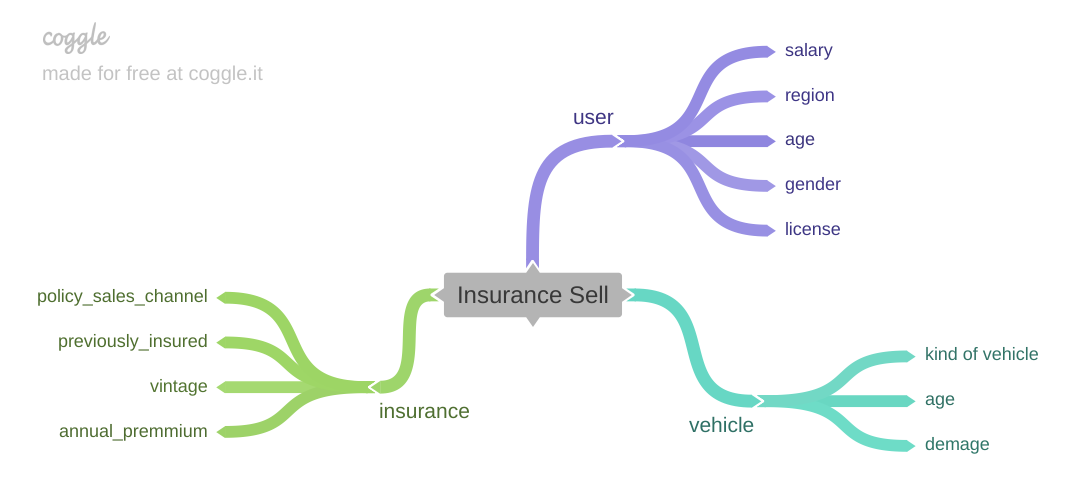

In [23]:
Image('../img/insurance_sell.png')

## 4.1. Univariate Analysis

### 4.1.1 Age

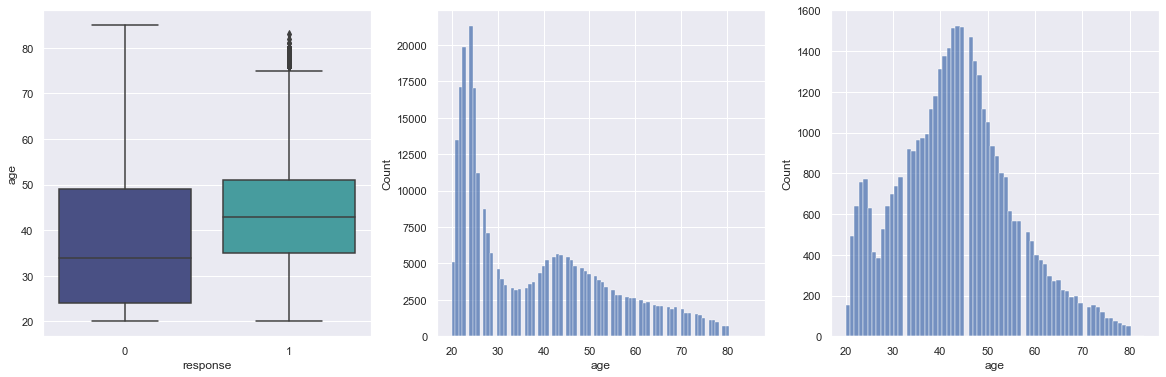

In [24]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='age', data=df04, palette='mako')

aux00 = df04.loc[df04['response'] == 0, 'age']
plt.subplot(1,3,2)
sns.histplot(aux00, palette='mako');

aux00 = df04.loc[df04['response'] == 1, 'age']
plt.subplot(1,3,3)
sns.histplot(aux00, palette='mako');

### 4.1.1.2 Anual Premium

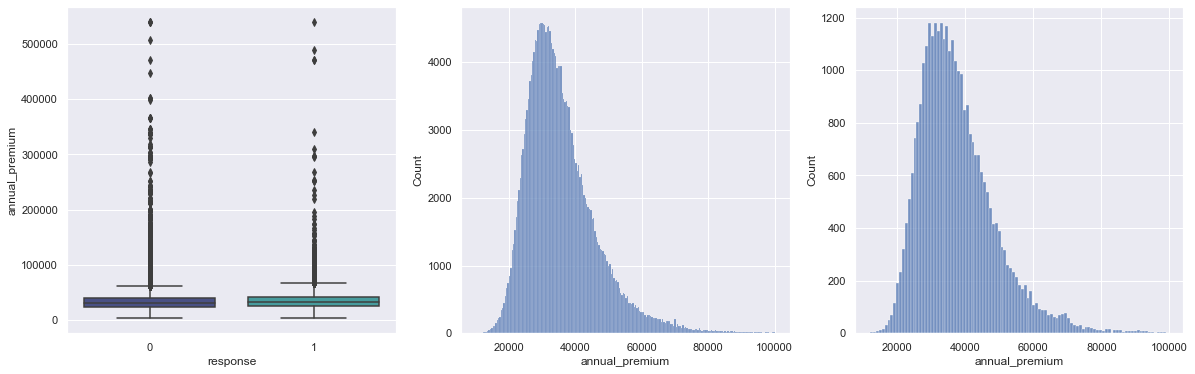

In [25]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='annual_premium', data=df04, palette='mako')

aux00 = df04[(df04['annual_premium'] > 10000) &(df04['annual_premium'] < 100000)]

aux01 = aux00.loc[aux00['response'] == 0, 'annual_premium']
plt.subplot(1,3,2)
sns.histplot(aux01, palette='mako');

aux01 = aux00.loc[aux00['response'] == 1, 'annual_premium']
plt.subplot(1,3,3)
sns.histplot(aux01, palette='mako');

### 4.1.3 Driving License

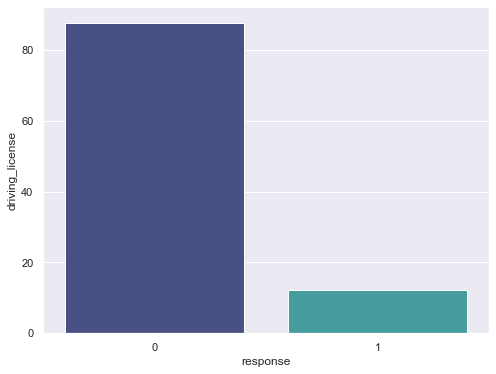

In [26]:
plt.figure(figsize=(8,6))

aux00 = df04[['driving_license', 'response']].groupby('response').sum().reset_index()
aux00['driving_license'] = (aux00['driving_license'] / aux00['driving_license'].sum())*100
sns.barplot(x='response', y='driving_license', data=aux00, palette='mako');

### 4.1.4. Region Code

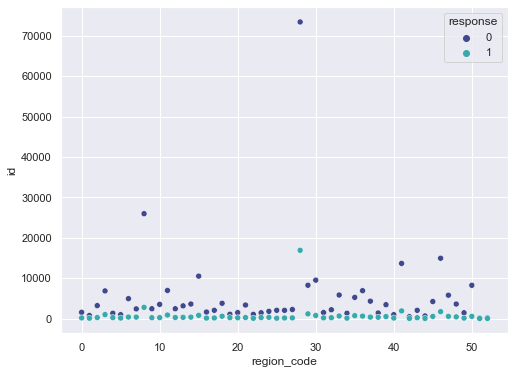

In [27]:
plt.figure(figsize=(8,6))

aux00 = df04[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux00, palette='mako');

### 4.1.5. Previously Insured

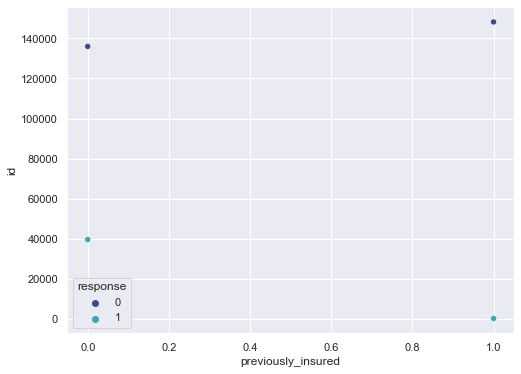

In [28]:
plt.figure(figsize=(8,6))

aux00 = df04[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()

sns.scatterplot(x='previously_insured', y='id', hue='response', data=aux00, palette='mako');

In [29]:
pd.crosstab(df04['previously_insured'], df04['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774607,0.225393
1,0.999137,0.000863


### 4.1.6. Vehicle Age

In [30]:
df04[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,133926
1,below_1_year,1,6098
2,between_1_2_year,0,140724
3,between_1_2_year,1,29578
4,over_2_years,0,9589
5,over_2_years,1,4027


### 4.1.7. Vehicle Damage

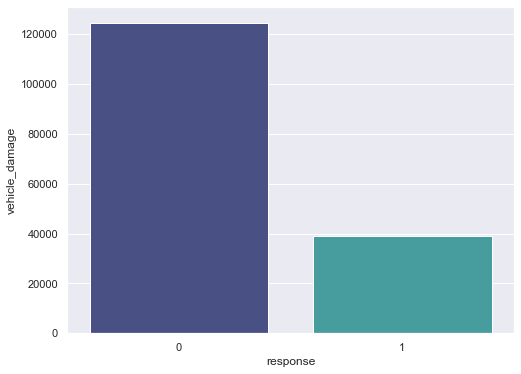

In [31]:
plt.figure(figsize=(8,6))

aux00 = df04[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux00, palette='mako');

###  4.1.8. Policy Sales Channel - Stacked Percentage Bar

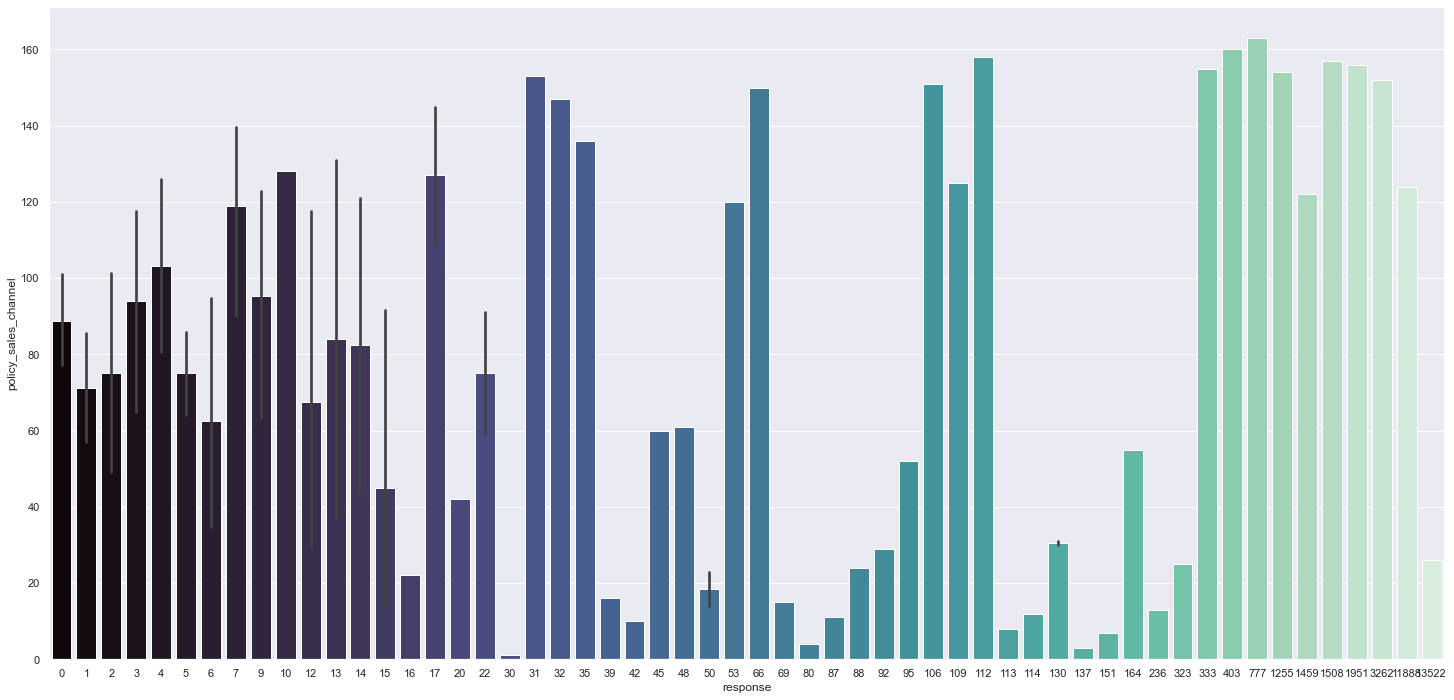

In [32]:
aux00 = df04[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux00, palette='mako');

### 4.1.9. Vintage

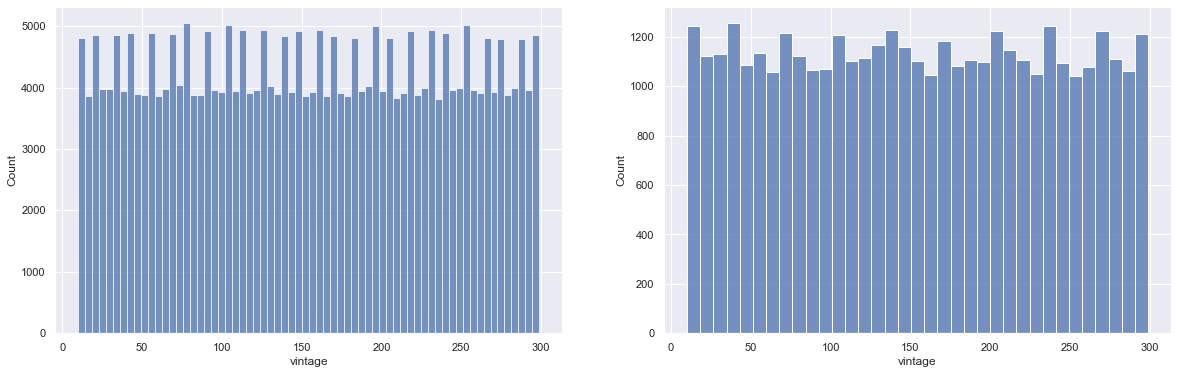

In [33]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
aux00 = df04.loc[df04['response'] == 0, 'vintage']
sns.histplot(aux00, palette='mako');

plt.subplot(1,2,2)
aux00 = df04.loc[df04['response'] == 1, 'vintage']
sns.histplot(aux00, palette='mako');

## 4.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

### 4.2.1 Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance more frequently
> - **H02** - Unlicensed customers do not purchase insurance
> - **H03** - Customers who already have vehicle insurance do not require the insurance offered
> - **H04** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H05** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H06** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H07** - Customers with the contract in force for longer do not acquire the insurance
> - **H08** - Elderly customers do not purchase insurance
> - **H09** - Female customers already have vehicle insurance
> - **H10** - Customers with new and damaged vehicles purchase the most insurance
> - **H11** - Customers who have a plan that covers more than the average in the region purchase the most insurance
> - **H12** - Older customers in the portfolio are from the region 28
> - **H13** - Young customers came through channel 152
> - **H14** - Of all age classes young people have the highest proportion of damaged cars

### 4.2.2 Final List of Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance
> - **H02** - Customers who already have vehicle insurance do not require the insurance offered
> - **H03** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H04** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H06** - Customers with the contract in force for longer do not acquire the insurance
> - **H07** - Customers with new and damaged vehicles purchase the most insurance
> - **H08** - Customers who have a plan that covers more than the average in the region purchase insurance
> - **H09** - Older customers in the portfolio are from the region 28
> - **H10** - Young customers came through channel 152
> - **H11** - Of all age classes young people have the highest proportion of damaged cars

#### **H01** - Customers over 30 years old purchase vehicle insurance more frequently
---
> **Conclusion: TRUE**
>> - Customers over 30 years old purchase vehicle insurance more frequently

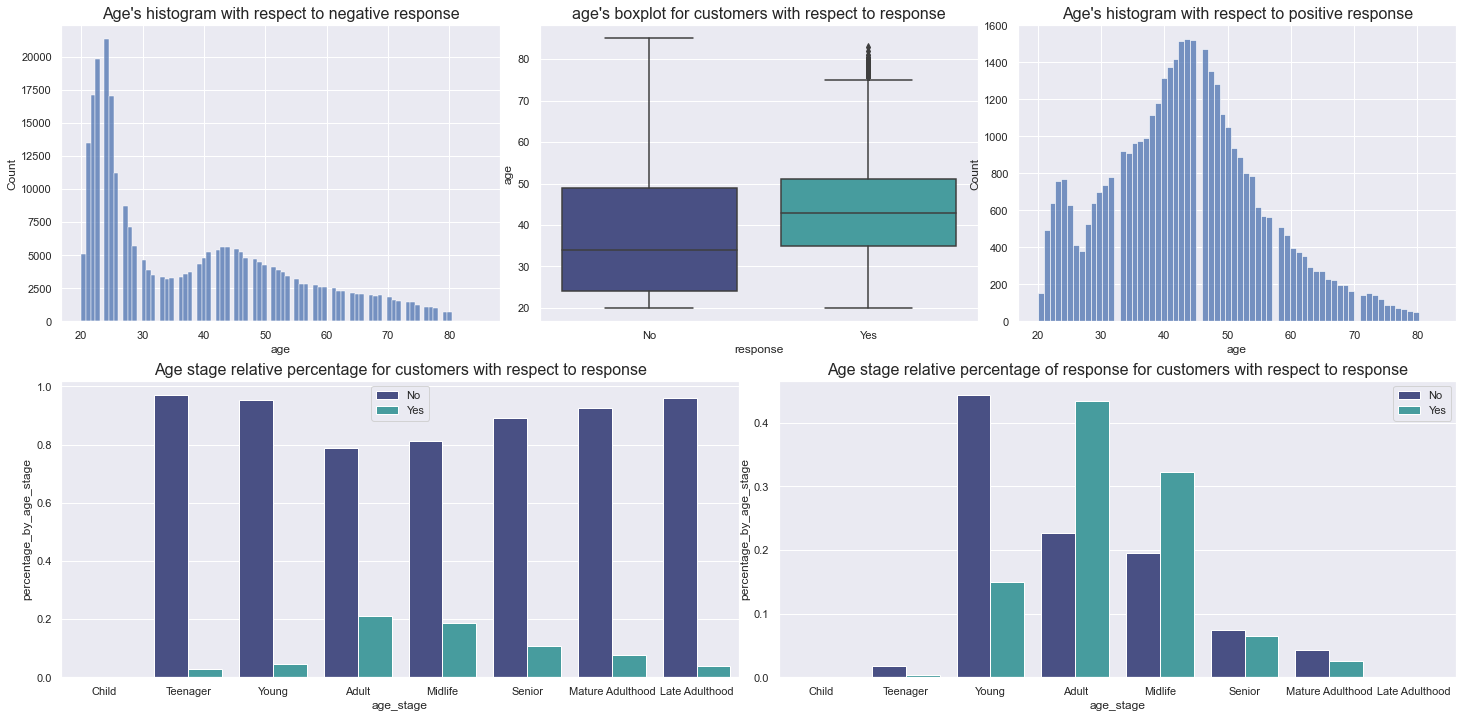

In [34]:
aux01 = df04[['age', 'age_stage', 'response']]

# Grid for ploting
grid = GridSpec(2, 6)

# Change response to Yes/No
aux01['response'] = aux01['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
# age's boxplot for customers with respect to response
plt.subplot(grid[0,2:4])
sns.boxplot(x="response", y="age", data=aux01, palette='mako').set_title("age's boxplot for customers with respect to response", fontsize=16);

# Histgram age & response == No
aux00 = df04.loc[df04['response'] == 0, 'age']
plt.subplot(grid[0,:2])
sns.histplot(aux00, palette='mako');
plt.title("Age's histogram with respect to negative response", fontsize=16);


# Histgram age & response == Yes
aux00 = df04.loc[df04['response'] == 1, 'age']
plt.subplot(grid[0,4:])
sns.histplot(aux00, palette='mako');
plt.title("Age's histogram with respect to positive response", fontsize=16);


# Age stage relative percentage for customers with respect to response
aux02 = pd.DataFrame()
age_stage_unique = aux01['age_stage'].unique().tolist()
for stage in age_stage_unique:
    aux02_0 = aux01[aux01['age_stage'] == stage][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
    aux02 = pd.concat([aux02, aux02_0])

## sort the x axis
age_stage_order = ['Child', 'Teenager', 'Young', 'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood']
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,:3])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02, palette='mako');
plt.legend();
plt.title("Age stage relative percentage for customers with respect to response", fontsize=16);

# Age stage relative percentage of response for customers with respect to response
aux02_0 = aux01[aux01['response'] == 'No'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
aux02_1 = aux01[aux01['response'] == 'Yes'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})

aux02 = pd.concat([aux02_0, aux02_1], axis=0)

## sort the x axis
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,3:])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02, palette='mako');
plt.legend();
plt.title("Age stage relative percentage of response for customers with respect to response", fontsize=16);

#### **H02** - Customers who already have vehicle insurance shouldn't require the insurance offered
---
> **Conclusion: TRUE**
>> - Customers who already have vehicle insurance do not require the insurance offered

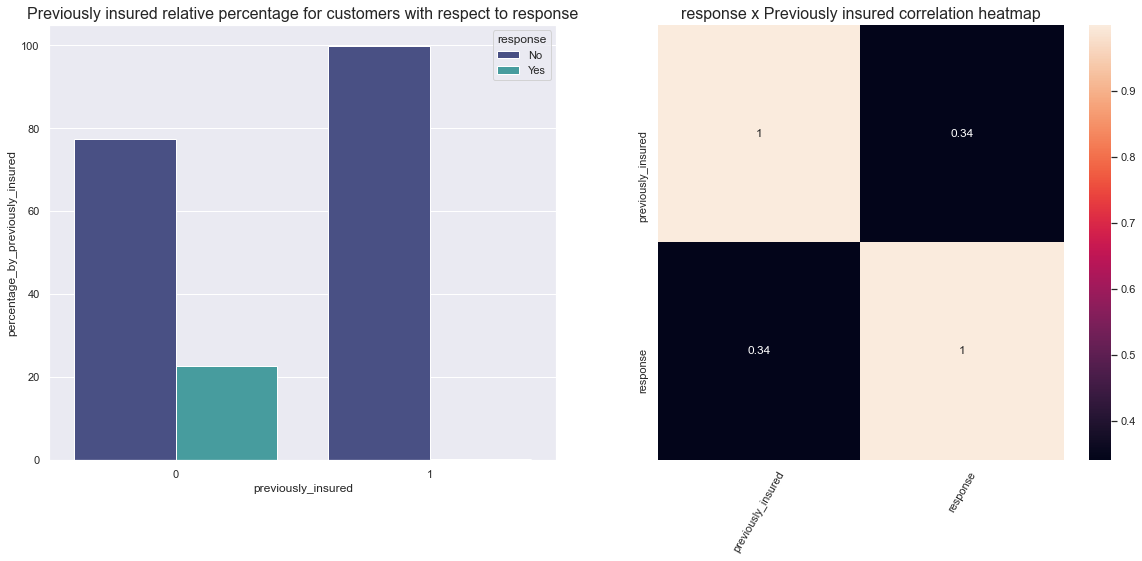

In [35]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
aux02 = df04[['previously_insured', 'response']]
# Previously insured relative percentage for customers with respect to response
aux02_0 = aux02[aux02['previously_insured'] == 1][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux02_1 = aux02[aux02['previously_insured'] == 0][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux03 = pd.concat([aux02_0, aux02_1], axis=0)

## Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
## transform to 100%
aux03['percentage_by_previously_insured'] = aux03['percentage_by_previously_insured'] * 100

## plot
sns.barplot(x='previously_insured', y='percentage_by_previously_insured', hue='response', data=aux03, palette='mako');
plt.title("Previously insured relative percentage for customers with respect to response", fontsize=16)

# response x previously insured correlation heatmap
d = categorical_correlation(aux02)

plt.subplot(1,2,2)
sns.heatmap(d, annot=True);
plt.title("response x Previously insured correlation heatmap", fontsize=16)
plt.xticks(rotation=60);

#### **H03** - Customers with vehicle that are less than 1 year old purchase insurance
---
> **Conclusion: FALSE**
>> - Customers with vehicle that are less than 1 year old do not purchase insurance

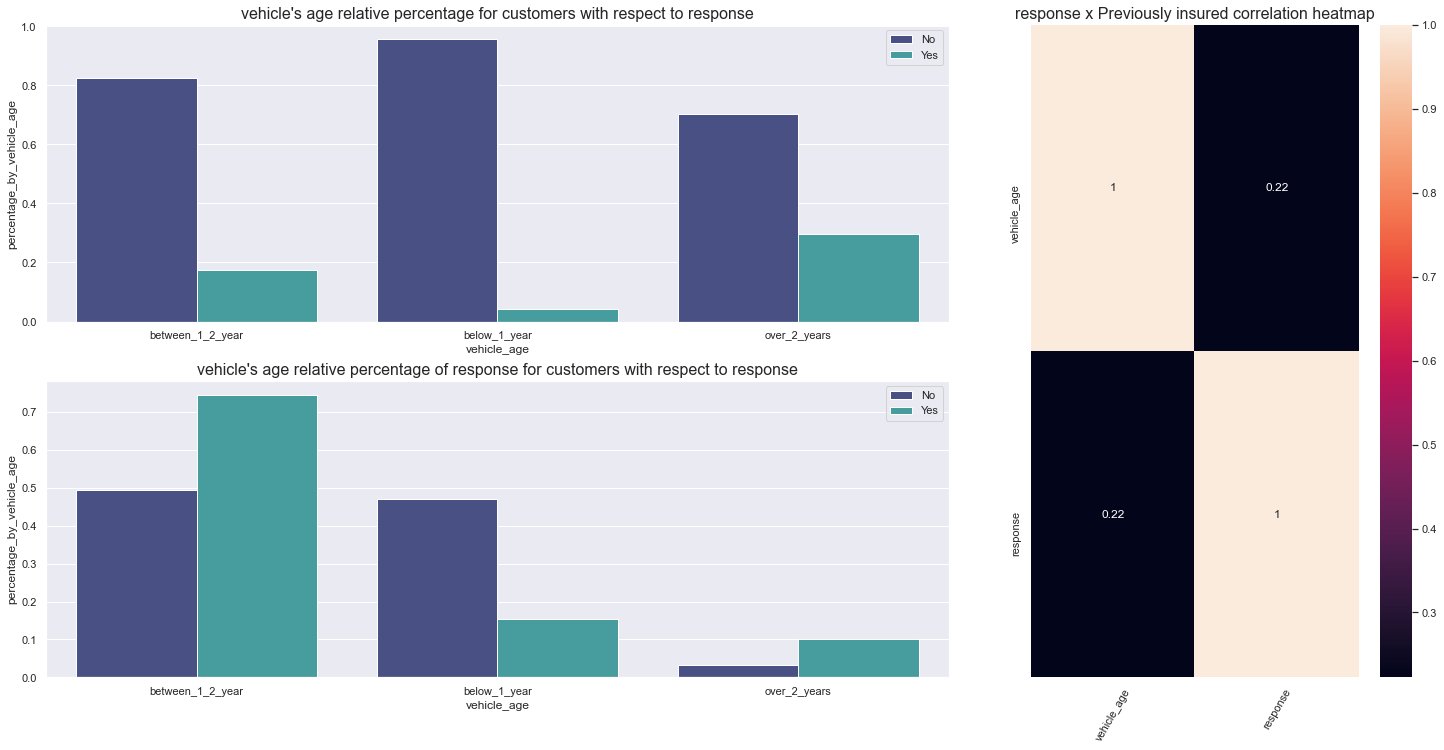

In [36]:
aux03 = df04[['vehicle_age', 'response']]

# Grid for ploting
plt.figure(figsize=(25, 12))
grid = GridSpec(2, 3)

# response x vehicle's age correlation heatmap
d = categorical_correlation(aux03)

plt.subplot(grid[:,2])
sns.heatmap(d, annot=True);
plt.title("response x Previously insured correlation heatmap", fontsize=16)
plt.xticks(rotation=60);


# Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# vehicle's age relative percentage for customers with respect to response
aux04 = pd.DataFrame()
vehicle_age_unique = aux03['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    aux04_0 = aux03[aux03['vehicle_age'] == age][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    aux04 = pd.concat([aux04, aux04_0])

## plot
plt.subplot(grid[0,:2])
# plt.subplot(2,1,1)
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux04, palette='mako');
plt.legend();
plt.title("vehicle's age relative percentage for customers with respect to response", fontsize=16);


# Age stage relative percentage of response for customers with respect to response
aux03_0 = aux03[aux03['response'] == 'No'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03_1 = aux03[aux03['response'] == 'Yes'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03 = pd.concat([aux03_0, aux03_1], axis=0)

## plot
plt.subplot(grid[1,:2])
# plt.subplot(2,1,2)
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux03, palette='mako');
plt.legend();
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

#### **H04** -  Longer customers who own vehicles that are more than 2 years old acquire insurance
---
> **Conclusion: FALSE**
>> - Longer customers who own vehicles that are more than 2 years old acquire insurance in the same frequency of the other customers

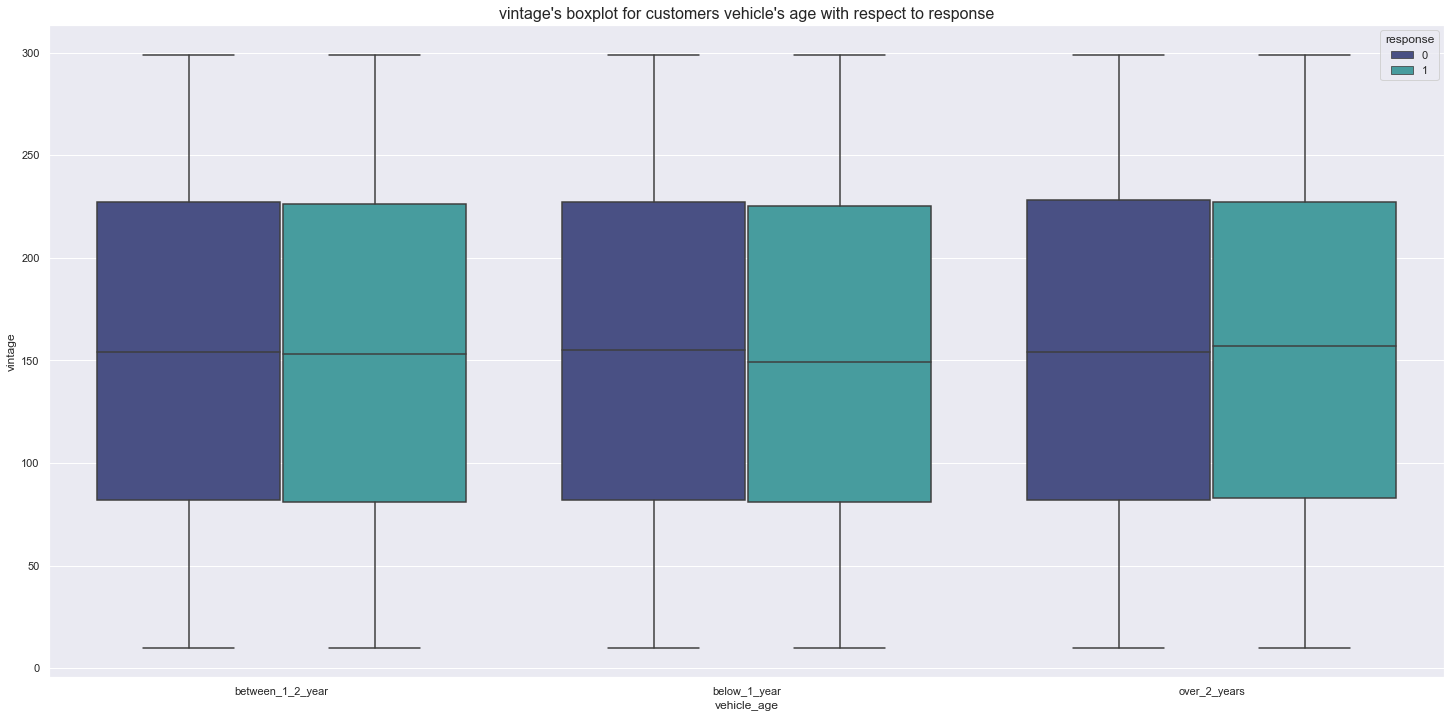

In [37]:
aux04 = df04[['vintage','vehicle_age', 'response']]

plt.figure(figsize=(25,12))
# age's boxplot for customers with respect to response
sns.boxplot(x="vehicle_age", y="vintage", hue="response", data=aux04, palette='mako').set_title("vintage's boxplot for customers vehicle's age with respect to response", fontsize=16);


#### **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
---
> **Conclusion: False**
>> - Male customers who own vehicles over 2 years of age acquire insurance

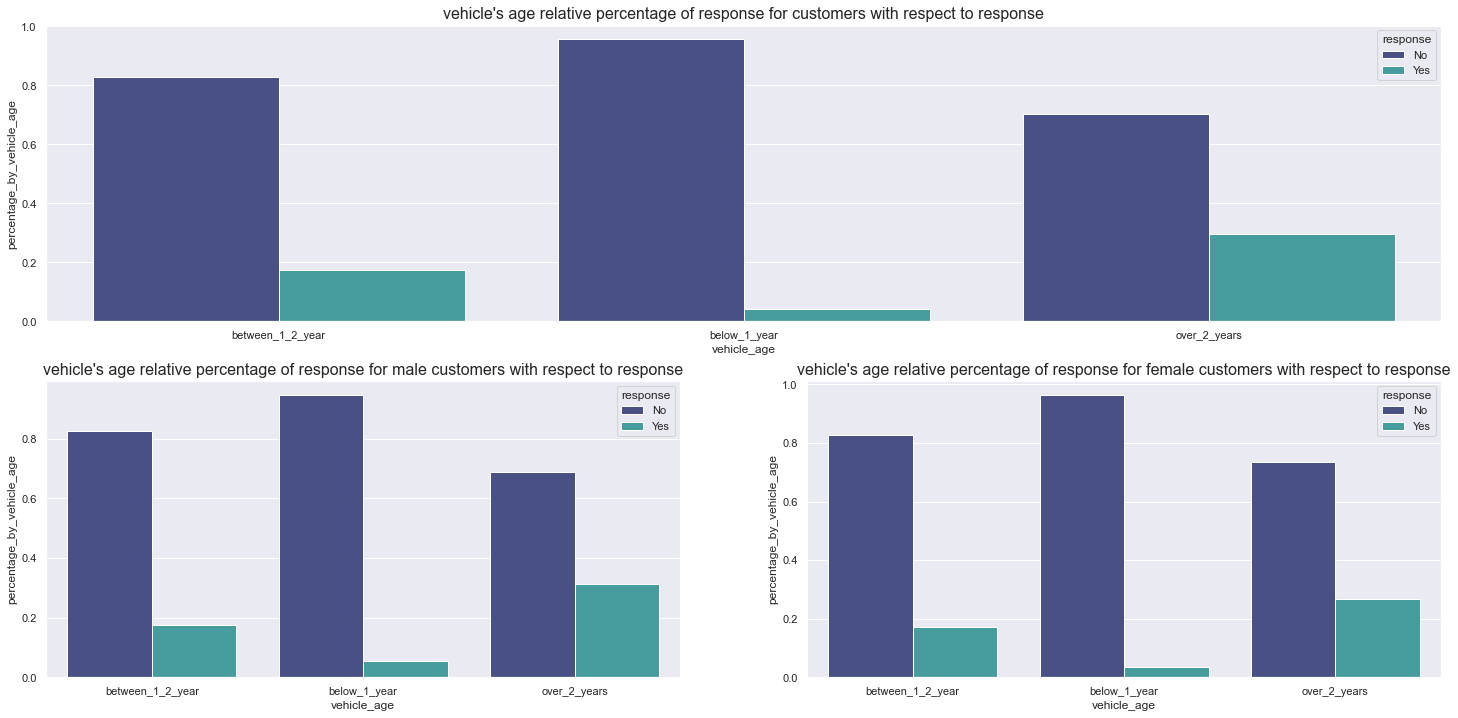

In [38]:
aux05 = df04[['gender','vehicle_age', 'response']]

aux05_0 = pd.DataFrame()
aux05_2 = pd.DataFrame()
aux05_4 = pd.DataFrame()
vehicle_age_unique = aux05['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    # All Genders
    aux05_1 = aux05[aux05['vehicle_age'] == age][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    # Male
    aux05_3 = aux05[(aux05['gender'] == 'Male') & (aux05['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    # Female
    aux05_5 = aux05[(aux05['gender'] == 'Female') & (aux05['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    
    # All genders
    aux05_0 = pd.concat([aux05_0, aux05_1])
    # Male
    aux05_2 = pd.concat([aux05_2, aux05_3])
    # Female
    aux05_4 = pd.concat([aux05_4, aux05_5])


# Change response to Yes/No
aux05_0['response'] = aux05_0['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux05_2['response'] = aux05_2['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux05_4['response'] = aux05_4['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

grid = GridSpec(2, 2)

plt.subplot(grid[0,:])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux05_0, palette='mako');
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

plt.subplot(grid[1,0])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux05_2, palette='mako');
plt.title("vehicle's age relative percentage of response for male customers with respect to response", fontsize=16);

plt.subplot(grid[1,1])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux05_4, palette='mako');
plt.title("vehicle's age relative percentage of response for female customers with respect to response", fontsize=16);

#### **H06** - Customers with the contract in force for longer do not acquire the insurance
---
> **Conclusion: FALSE**
>> - Customers with a longer-term contract purchase insurance in the same proportion as customers with a shorter-term contract

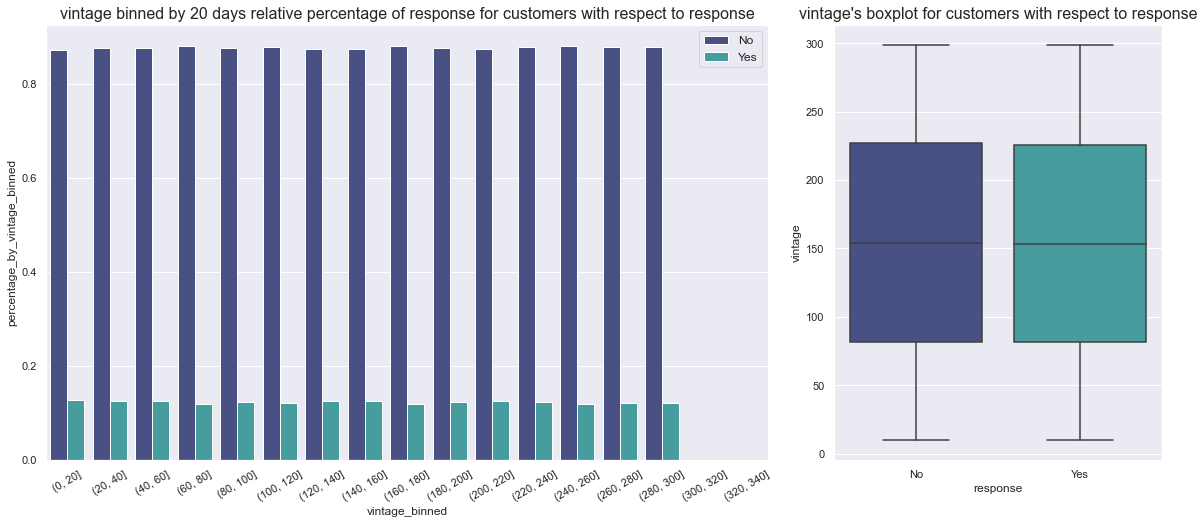

In [39]:
aux06 = df04[['vintage', 'response']]

# bins
bins = list(np.arange(0, 360, 20))

aux06['vintage_binned'] = pd.cut(aux06['vintage'], bins=bins)

# Change response to Yes/No
aux06['response'] = aux06['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

plt.figure(figsize=(20,8))
grid = GridSpec(1, 3)

vintage_binned_unique = aux06['vintage_binned'].unique().tolist()

aux06_0 = pd.DataFrame()
for vintage_bin in vintage_binned_unique:
    aux06_1 = aux06[aux06['vintage_binned'] == vintage_bin][['vintage_binned', 'response']].\
                                                value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vintage_binned'})
    aux06_0 = pd.concat([aux06_0, aux06_1])

plt.subplot(grid[0,:2])    
sns.barplot(x='vintage_binned', y='percentage_by_vintage_binned', hue='response', data=aux06_0, palette='mako');
plt.title("vintage binned by 20 days relative percentage of response for customers with respect to response", fontsize=16);
plt.legend(loc='upper right', fontsize='medium')
plt.xticks(rotation=30);

plt.subplot(grid[0,2:])
sns.boxplot(x='response', y='vintage', data=aux06, palette='mako').set_title("vintage's boxplot for customers with respect to response", fontsize=16);

#### **H07** - Customers with new and damaged vehicles purchase the most insurance
---
> **Conclusion: FALSE**
>> - Customers with new and damaged vehicles purchase the less insurance

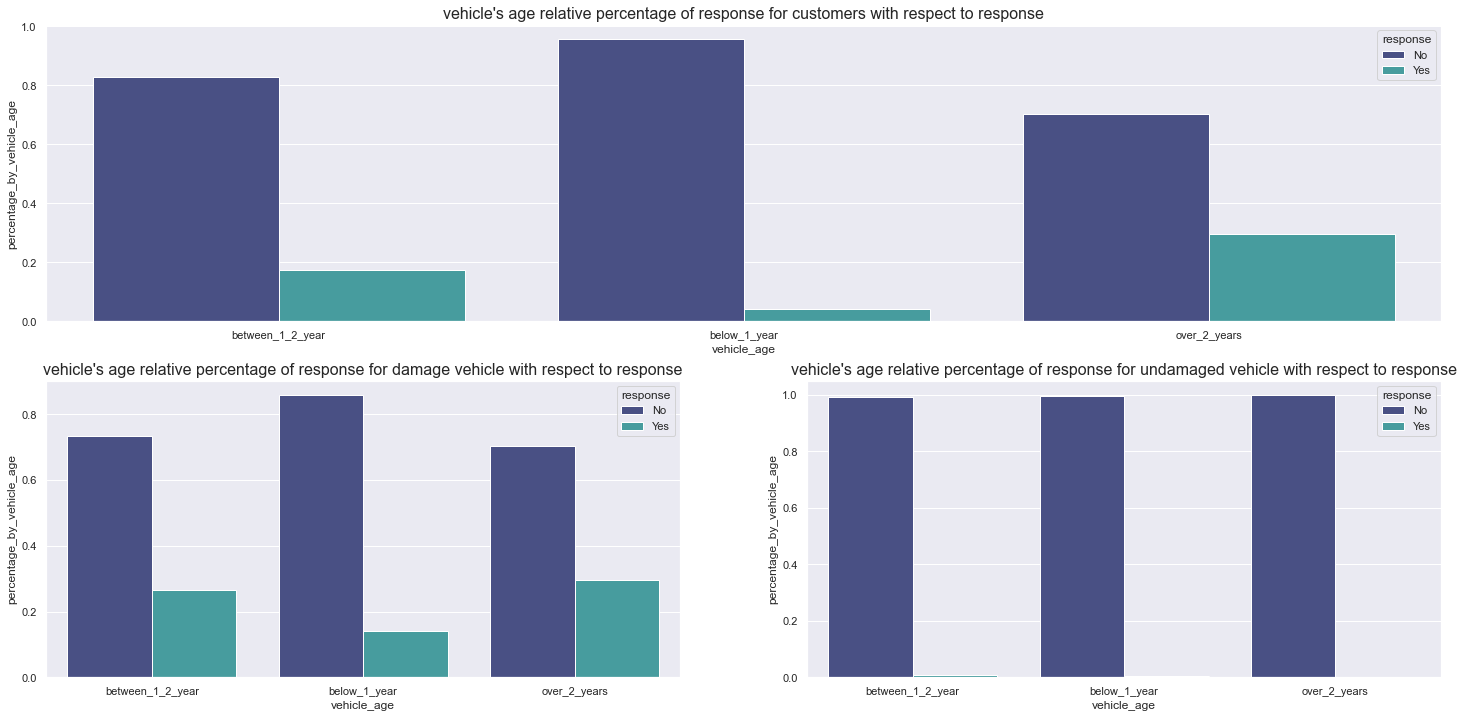

In [40]:
aux07 = df04[['vehicle_age', 'vehicle_damage', 'response']]

vehicle_age_unique = aux07['vehicle_age'].unique().tolist()


aux07_0 = pd.DataFrame()
aux07_2 = pd.DataFrame()
aux07_4 = pd.DataFrame()
for age in vehicle_age_unique:
    # damaged vehicle not applied
    aux07_1 = aux07[aux07['vehicle_age'] == age][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})    
    # damage vehicle True
    aux07_3 = aux07[(aux07['vehicle_damage'] == 1) & (aux07['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    # damage vehicle False
    aux07_5 = aux07[(aux07['vehicle_damage'] == 0) & (aux07['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    
    # damaged vehicle not applied
    aux07_0 = pd.concat([aux07_0, aux07_1])
    # damage vehicle True
    aux07_2 = pd.concat([aux07_2, aux07_3])
    # damage vehicle False
    aux07_4 = pd.concat([aux07_4, aux07_5])


# Change response to Yes/No
aux07_0['response'] = aux07_0['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux07_2['response'] = aux07_2['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux07_4['response'] = aux07_4['response'].apply(lambda row: 'Yes' if row == 1 else 'No')


grid = GridSpec(2, 2)

plt.subplot(grid[0,:])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux07_0, palette='mako');
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

plt.subplot(grid[1,0])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux07_2, palette='mako');
plt.title("vehicle's age relative percentage of response for damage vehicle with respect to response", fontsize=16);

plt.subplot(grid[1,1])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux07_4, palette='mako');
plt.title("vehicle's age relative percentage of response for undamaged vehicle with respect to response", fontsize=16);

#### **H08** - Customers who have a plan that covers more than the average in the region purchase the most insurance
---
> **Conclusion: FALSE**
>> - Customers who have a plan that covers more than the average in the region purchase the same proportion insurance

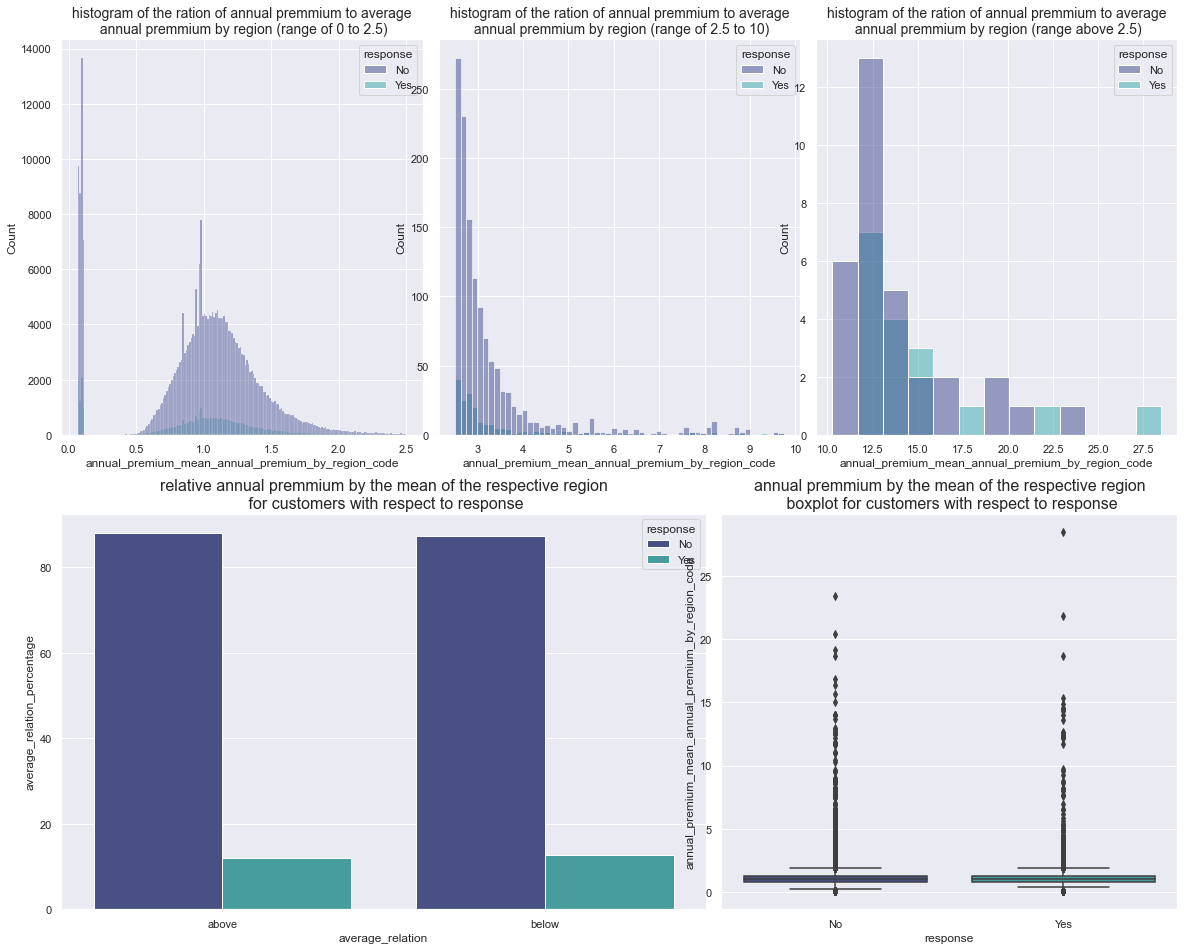

In [41]:
region_code_mean_annual_premium = pd.DataFrame(df04.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
aux08 = pd.merge(df04, region_code_mean_annual_premium, how='left', on='region_code')
del region_code_mean_annual_premium 

aux08['annual_premium_mean_annual_premium_by_region_code'] = aux08['annual_premium'] / aux08['mean_annual_premium_by_region_code']
aux08 = aux08[['annual_premium_mean_annual_premium_by_region_code', 'response']]


# Change response to Yes/No
aux08['response'] = aux08['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

cort = 2.5
cort_2 = 10

aux08_0 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] < cort]
aux08_1 = aux08[(aux08['annual_premium_mean_annual_premium_by_region_code'] >= cort) & (aux08['annual_premium_mean_annual_premium_by_region_code'] < cort_2)]
aux08_2 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] >= cort_2]

plt.figure(figsize=(20, 16))
grid = GridSpec(2, 12)

plt.subplot(grid[0, :4])
sns.histplot(x='annual_premium_mean_annual_premium_by_region_code', data=aux08_0, hue='response', palette='mako');
plt.title("histogram of the ration of annual premmium to average\n annual premmium by region (range of 0 to {})".format(cort), fontsize=14);

plt.subplot(grid[0, 4:8])
sns.histplot(x='annual_premium_mean_annual_premium_by_region_code', data=aux08_1, hue='response', palette='mako');
plt.title("histogram of the ration of annual premmium to average\n annual premmium by region (range of {} to {})".format(cort,cort_2), fontsize=14);

plt.subplot(grid[0, 8:])
sns.histplot(x='annual_premium_mean_annual_premium_by_region_code', data=aux08_2, hue='response', palette='mako');
plt.title("histogram of the ration of annual premmium to average\n annual premmium by region (range above {})".format(cort), fontsize=14);


aux08_3 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] > 1].groupby('response').size().reset_index().rename(columns={0:"total"})
aux08_3['average_relation_percentage'] = aux08_3['total'] / aux08_3['total'].sum() * 100
aux08_3['average_relation'] = 'above'

aux08_4 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] <= 1].groupby('response').size().reset_index().rename(columns={0:"total"})
aux08_4['average_relation_percentage'] = aux08_4['total'] / aux08_4['total'].sum() * 100
aux08_4['average_relation'] = 'below'

aux08_4 = pd.concat([aux08_3, aux08_4], axis=0)

plt.subplot(grid[1, :7])
sns.barplot(x='average_relation', y='average_relation_percentage', hue='response', data=aux08_4, palette='mako');
plt.title("relative annual premmium by the mean of the respective region\n for customers with respect to response", fontsize=16);

plt.subplot(grid[1, 7:])
sns.boxplot(x='response', y='annual_premium_mean_annual_premium_by_region_code', data=aux08, palette='mako');
plt.title("annual premmium by the mean of the respective region\n boxplot for customers with respect to response", fontsize=16);

#### **H09** - Older customers in the portfolio are from the region 28
---
> **Conclusion: FALSE**
>> - the vintage ratio is equally distributed

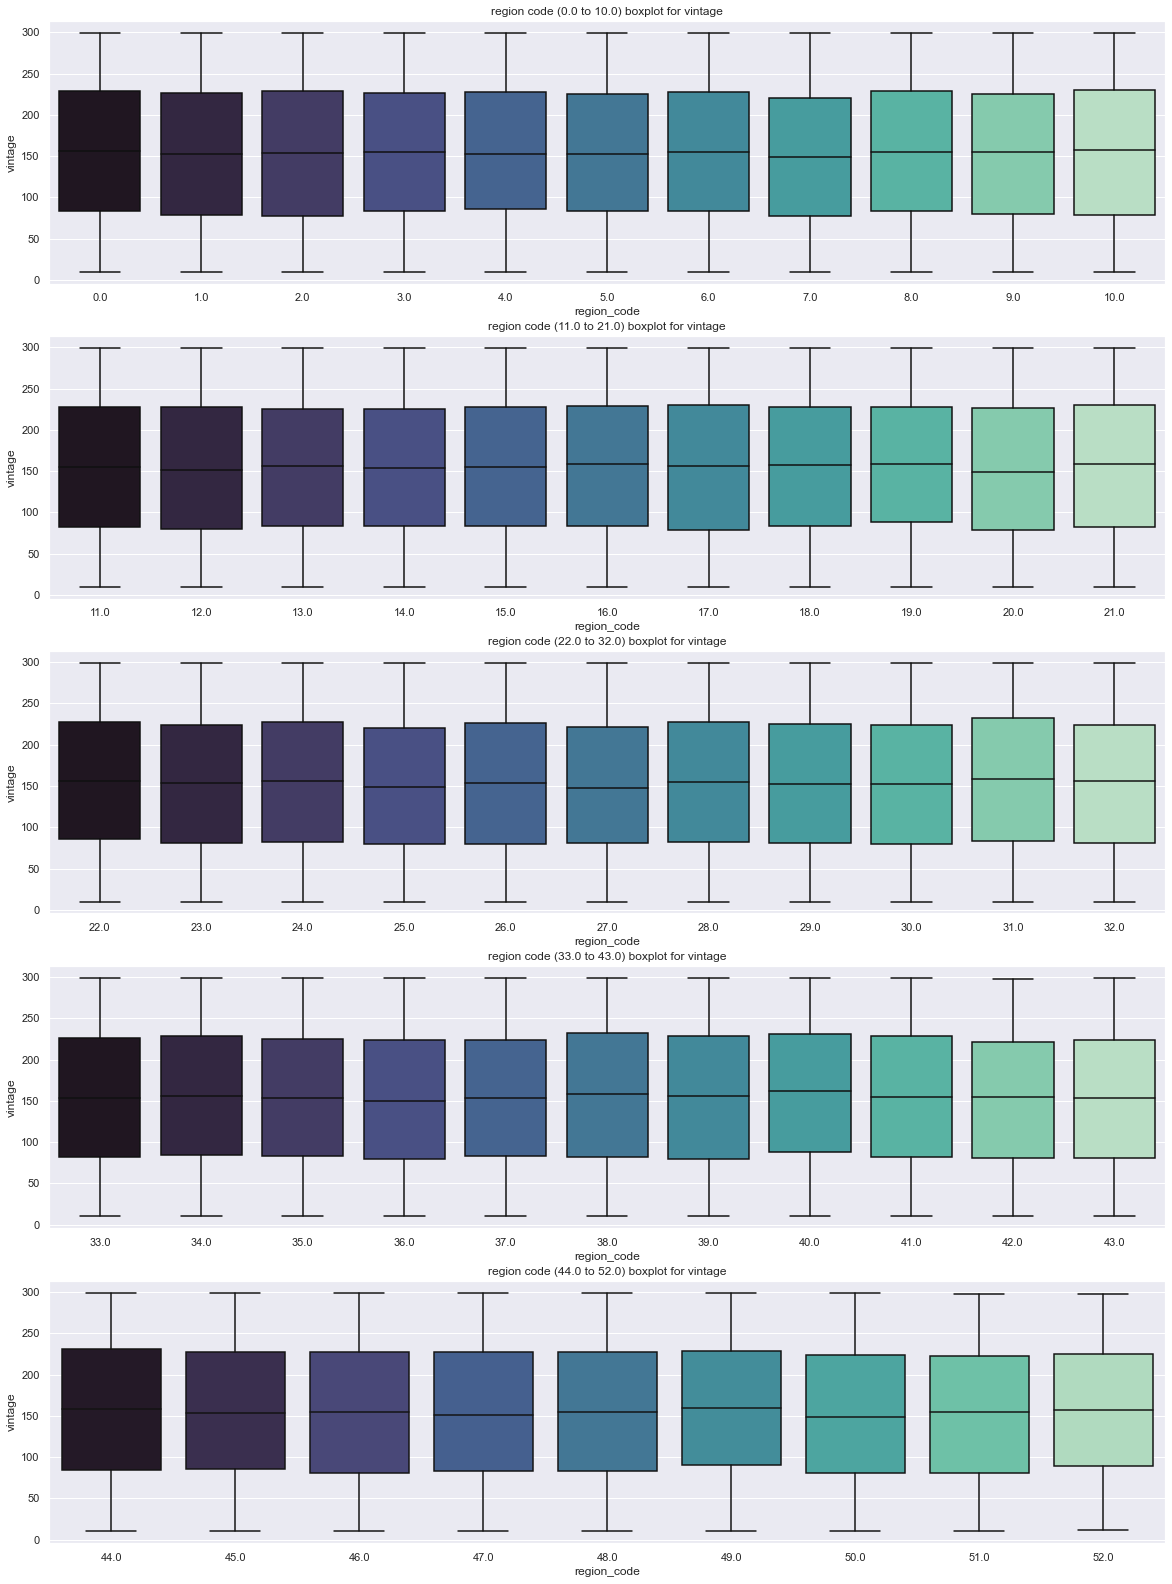

In [42]:
aux09 = df04[['vintage', 'region_code']].sort_values('region_code')

num_of_plots = 5
range_plots = round(len(aux09['region_code'].unique().tolist())/num_of_plots)
list_region_code = aux09['region_code'].unique().tolist()

plt.figure(figsize=(20, 28));

for i in range(num_of_plots):
    if i != num_of_plots - 1:
        aux09_1 = aux09[aux09['region_code'].isin(list_region_code[i * range_plots:(i+1) * range_plots])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='region_code', y='vintage', data=aux09_1, palette='mako');
        plt.title("region code ({} to {}) boxplot for vintage".format(list_region_code[i * range_plots], list_region_code[(i+1) * range_plots -1]));

    else:
        aux09_1 = aux09[aux09['region_code'].isin(list_region_code[i * range_plots:])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='region_code', y='vintage', data=aux09_1, palette='mako');
        plt.title("region code ({} to {}) boxplot for vintage".format(list_region_code[i * range_plots], list_region_code[-1]));

#### **H10** - Young customers came through channel 152
---
> **Conclusion: FALSE**
>> - Young customers came through channel 159

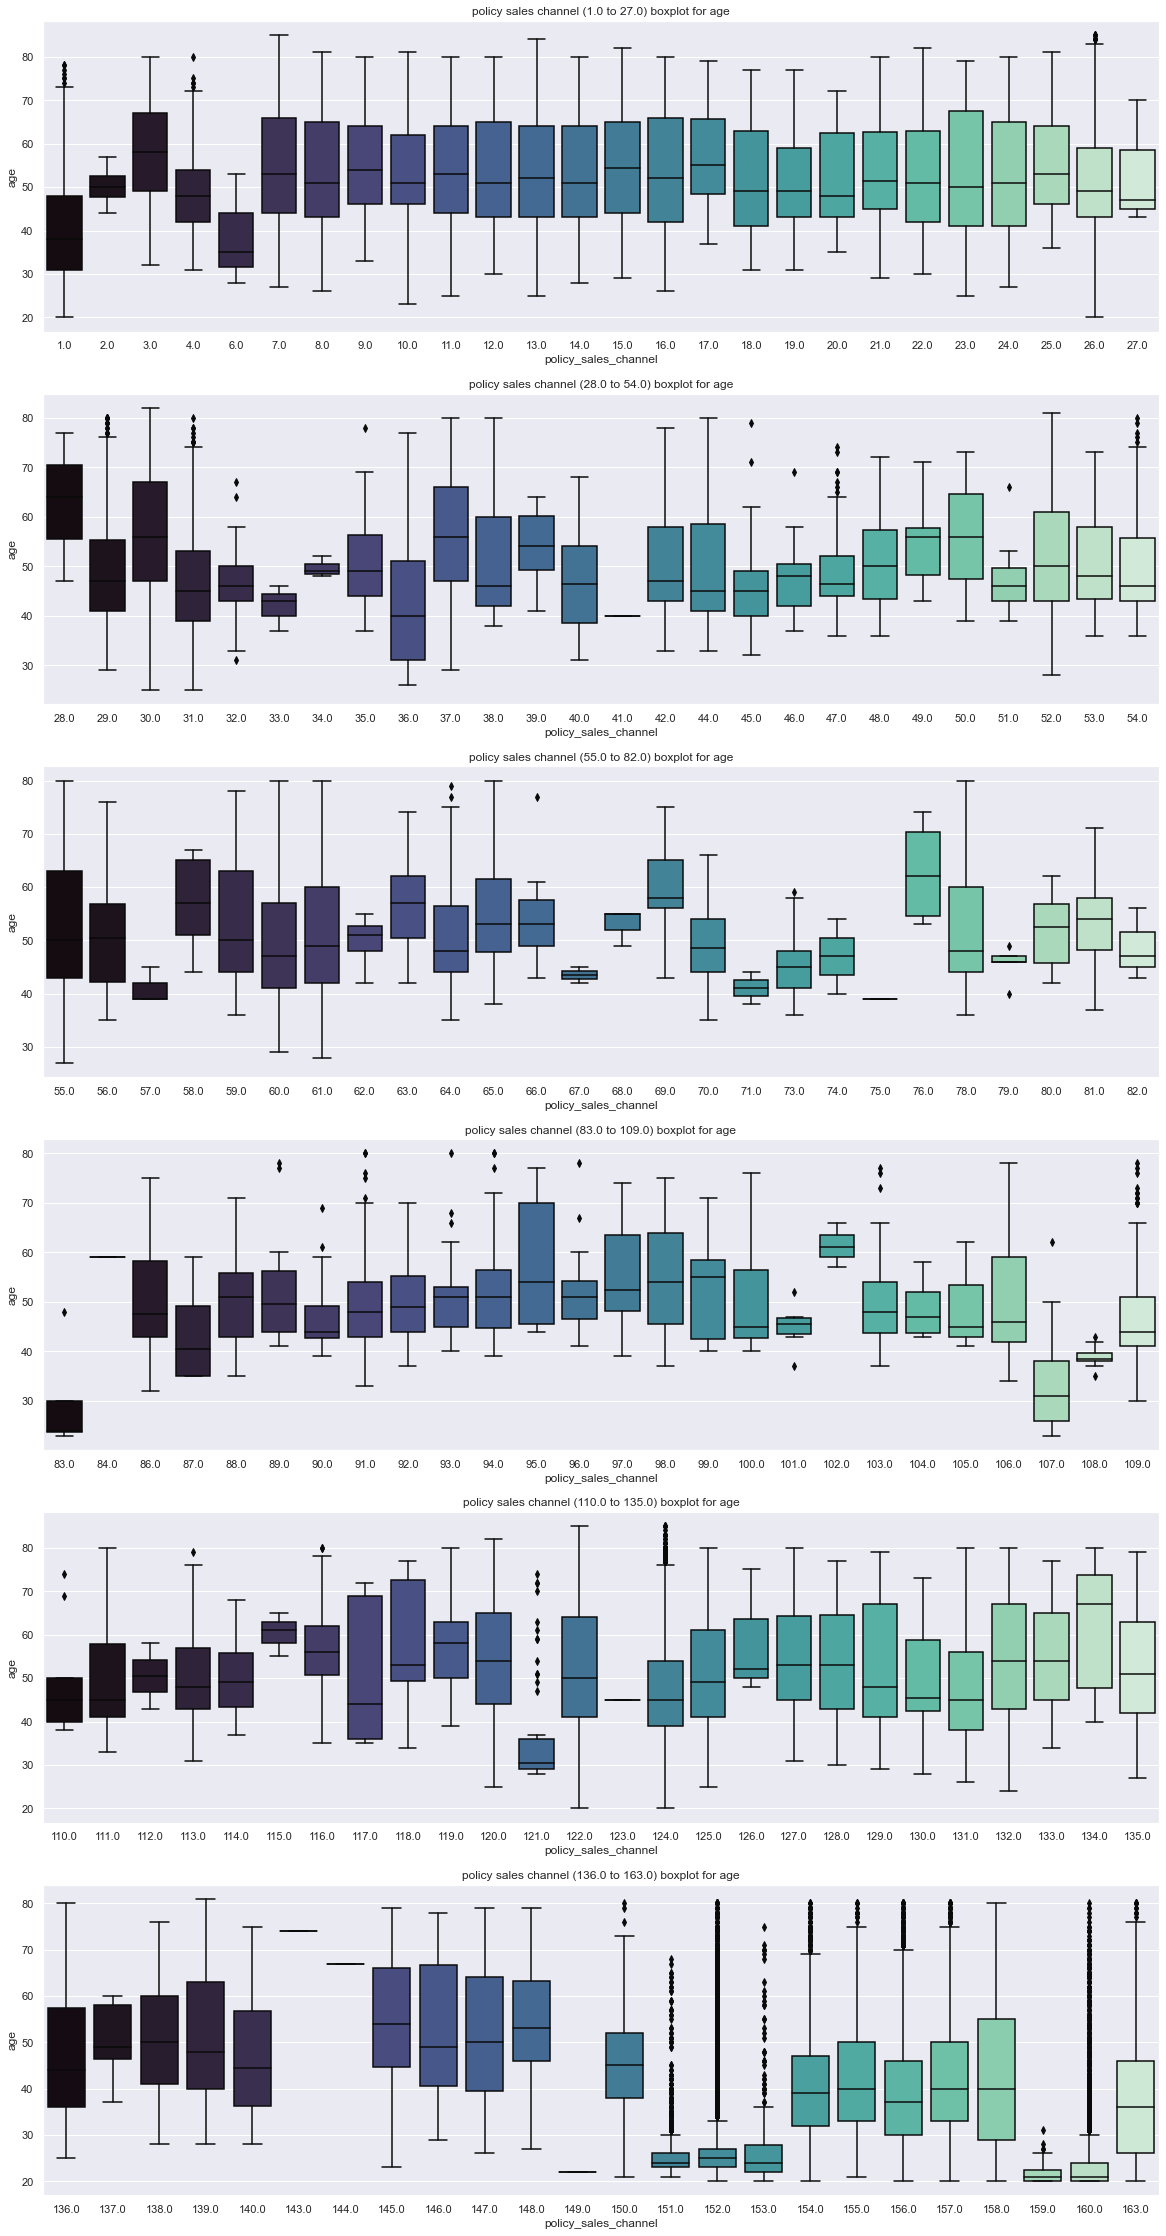

In [43]:
aux10 = df04[['age', 'policy_sales_channel']].sort_values('policy_sales_channel')

num_of_plots = 6
range_plots = round(len(aux10['policy_sales_channel'].unique().tolist())/num_of_plots)
list_region_code = aux10['policy_sales_channel'].unique().tolist()

plt.figure(figsize=(20, 40));

for i in range(num_of_plots):
    if i != num_of_plots - 1:
        aux10_1 = aux10[aux10['policy_sales_channel'].isin(list_region_code[i * range_plots:(i+1) * range_plots])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='policy_sales_channel', y='age', data=aux10_1, palette='mako');
        plt.title("policy sales channel ({} to {}) boxplot for age".format(list_region_code[i * range_plots], list_region_code[(i+1) * range_plots -1]));

    else:
        aux10_1 = aux10[aux10['policy_sales_channel'].isin(list_region_code[i * range_plots:])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='policy_sales_channel', y='age', data=aux10_1, palette='mako');
        plt.title("policy sales channel ({} to {}) boxplot for age".format(list_region_code[i * range_plots], list_region_code[-1]));


#### **H11** - Of all age classes young people have the highest proportion of damaged cars
---
> **Conclusion: FALSE**
>> - Of all age classes Midlife people have the highest proportion of damaged cars

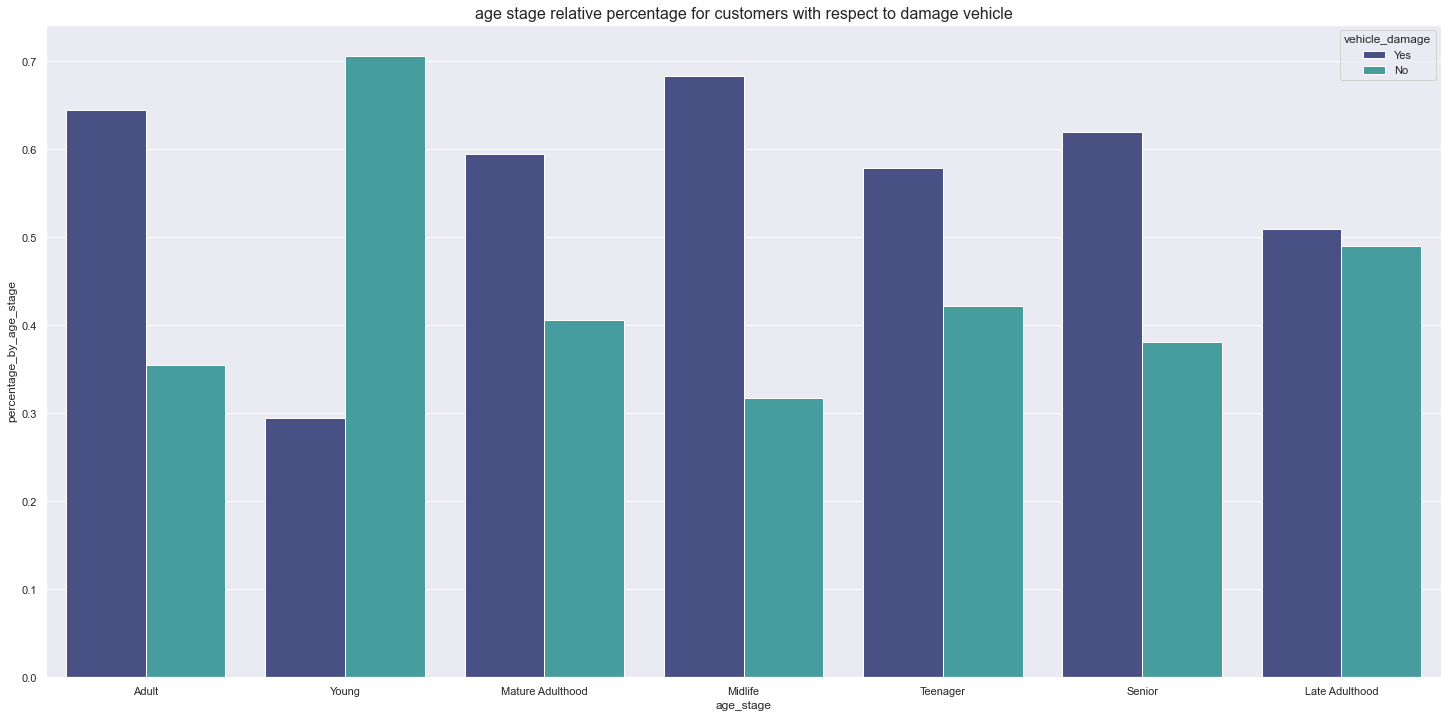

In [44]:
aux11 = df04[['age_stage', 'vehicle_damage']]

# Change response to Yes/No
aux11['vehicle_damage'] = aux11['vehicle_damage'].apply(lambda row: 'Yes' if row == 1 else 'No')

age_stage_unique = aux11['age_stage'].unique().tolist()

aux11_0 = pd.DataFrame()

for age in age_stage_unique:
    # 
    aux11_1 = aux11[aux11['age_stage'] == age][['age_stage', 'vehicle_damage']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})    
    
    # 
    aux11_0 = pd.concat([aux11_0, aux11_1])
    
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='vehicle_damage', data=aux11_0, palette='mako');
plt.title("age stage relative percentage for customers with respect to damage vehicle", fontsize=16);

## 4.3 Multivariable analysis (Balanced Dataset)

In [45]:
cat_cols = ['region_code', 'policy_sales_channel', 'driving_license', 'vehicle_damage']

num_attributes = df04.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(cat_cols, axis=1)

cat_attributes = df04.select_dtypes(exclude=['int64', 'float64'])
cat_attributes_list = cat_attributes.columns.tolist()
cat_attributes_list.extend(cat_cols)
cat_attributes = df04[cat_attributes_list]

### 4.3.1 Numerical

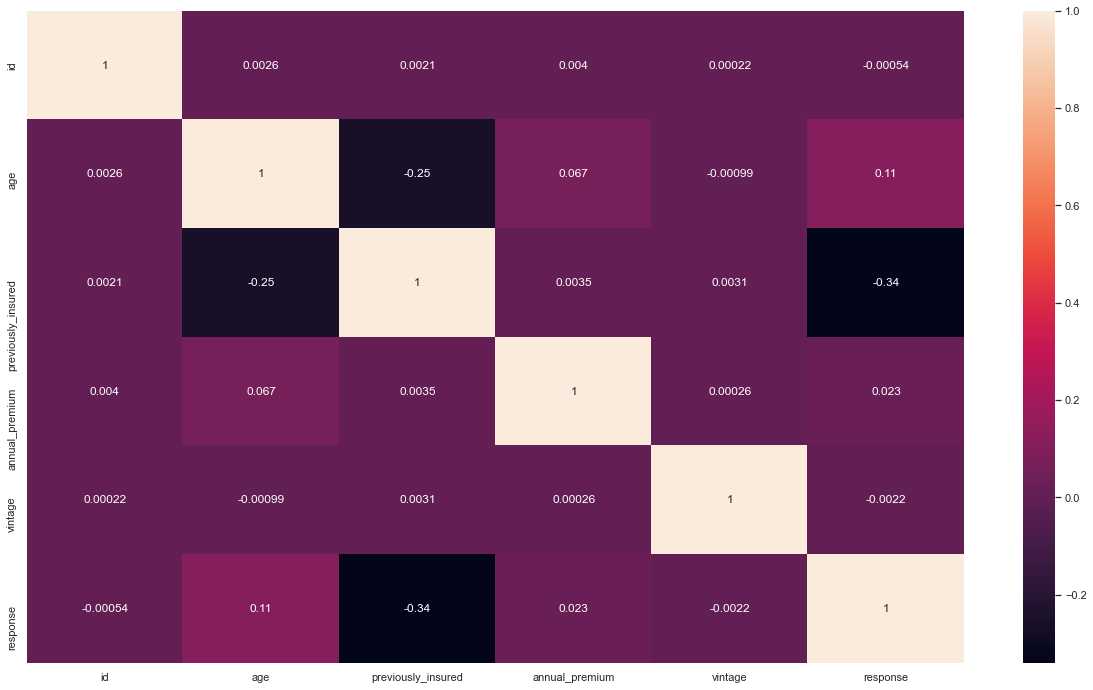

In [46]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical

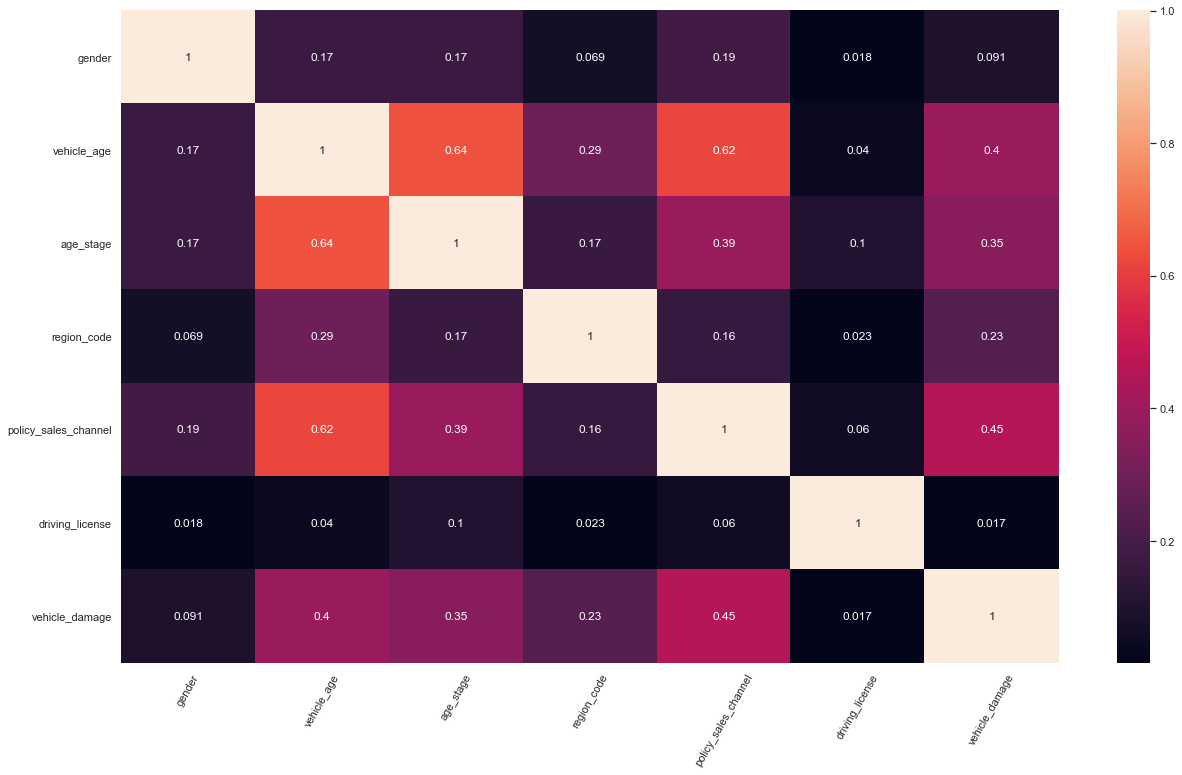

In [47]:
d = categorical_correlation(cat_attributes)

plt.figure(figsize=(21,12))
sns.heatmap(d, annot=True);
plt.xticks(rotation=60);

# 5.0. Data Preparation

In [48]:
X = df04.drop( 'response', axis=1)
y = df04['response'].copy() 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

df05 = pd.concat([X_train, y_train], axis=1)

## 5.1. Standardization

In [49]:
ss = StandardScaler()

# anual premium - StandarScaler
df05['annual_premium'] = ss.fit_transform( df05[['annual_premium']].values )

## 5.2. Rescaling

In [50]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# Age - MinMaxScaler
df05['age'] = mms_age.fit_transform(df05[['age']].values)

# Vintage - MinMaxScaler
df05['vintage'] = mms_vintage.fit_transform( df05[['vintage']].values )

## 5.3. Transformation

In [51]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df05.groupby('gender')['response'].mean()
df05.loc[:, 'gender'] = df05['gender'].map(target_encode_gender)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df05.groupby('region_code')['response'].mean()
df05.loc[:, 'region_code'] = df05['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding / Frequency Encoding
df05 = pd.get_dummies(df05, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df05.groupby('policy_sales_channel').size() / len(df05) 
df05.loc[:, 'policy_sales_channel'] = df05['policy_sales_channel'].map(fe_policy_sales_channel)

# age_stage - Target Encoding / Frequency Encoding
fe_age_stage = df05.groupby('age_stage').size() / len(df05) 
df05.loc[:, 'age_stage'] = df05['age_stage'].map(fe_age_stage)

## 5.4. Validation Preparation

In [52]:
# gender
X_val.loc[:, 'gender'] =  X_val.loc[:, 'gender'].map(target_encode_gender)

# age
X_val.loc[:, 'age'] = mms_age.transform(X_val[['age']].values)

# region_code
X_val.loc[:, 'region_code'] = X_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
X_val = pd.get_dummies(X_val, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
X_val.loc[:, 'annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# policy_sales_channel
X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
X_val.loc[:, 'vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# age_stage
X_val.loc[:, 'age_stage'] = X_val['age_stage'].map(fe_age_stage)

# fillna
X_val = X_val.fillna(0)

## 5.5 Balanced

In [53]:
X = df05.drop('response', axis=1)
y = df05['response'].copy()

In [54]:
y.value_counts()

0    227326
1     31827
Name: response, dtype: int64

In [55]:
ratio_balanced = {0: 227326,
                  1: 7*31827}

ratio_balanced

{0: 227326, 1: 222789}

In [56]:
# define sampler
smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=9, n_jobs=-1)


# apply sampler
X_smt, y_smt = smt.fit_resample(X, y)

#  6.0. Feature Selection

##  6.1. Boruta Algorithm

In [57]:
X_train_n = X_smt.drop(['id'], axis=1).values
y_train_n = y_smt.values.ravel()

# Define model
et = ExtraTreesClassifier(n_estimators=250, random_state=9, n_jobs=-1)
# xgb = XGBClassifier(n_jobs=-1,random_state=9, verbosity=0)

# Define boruta
boruta = BorutaPy(et, n_estimators='auto', verbose=2, random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	2


BorutaPy(estimator=ExtraTreesClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=RandomState(MT19937) at 0x2925D301040),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2925D301040, verbose=2)

In [58]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_smt.drop(['id'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['gender',
 'age',
 'region_code',
 'policy_sales_channel',
 'vehicle_damage',
 'previously_insured',
 'annual_premium',
 'vintage',
 'age_stage',
 'vehicle_age_below_1_year',
 'vehicle_age_between_1_2_year']

## 6.2. Feature Importance

In [59]:
# model definition
forest = ExtraTreesClassifier(n_estimators=250, random_state=9, n_jobs=-1)
#xgb = XGBClassifier(n_jobs=-1,random_state=9, verbosity=0)

# data preparation
X_train_n = X_smt.drop(['id'], axis=1)
y_train_n = y_smt.values
forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=9)

Feature ranking:
                        feature  importance
0            previously_insured    0.176624
0                vehicle_damage    0.140237
0      vehicle_age_below_1_year    0.109396
0          policy_sales_channel    0.090547
0                       vintage    0.077440
0                     age_stage    0.076392
0                annual_premium    0.076183
0                           age    0.072942
0                   region_code    0.066579
0                        gender    0.059519
0  vehicle_age_between_1_2_year    0.034535
0      vehicle_age_over_2_years    0.019243
0               driving_license    0.000364


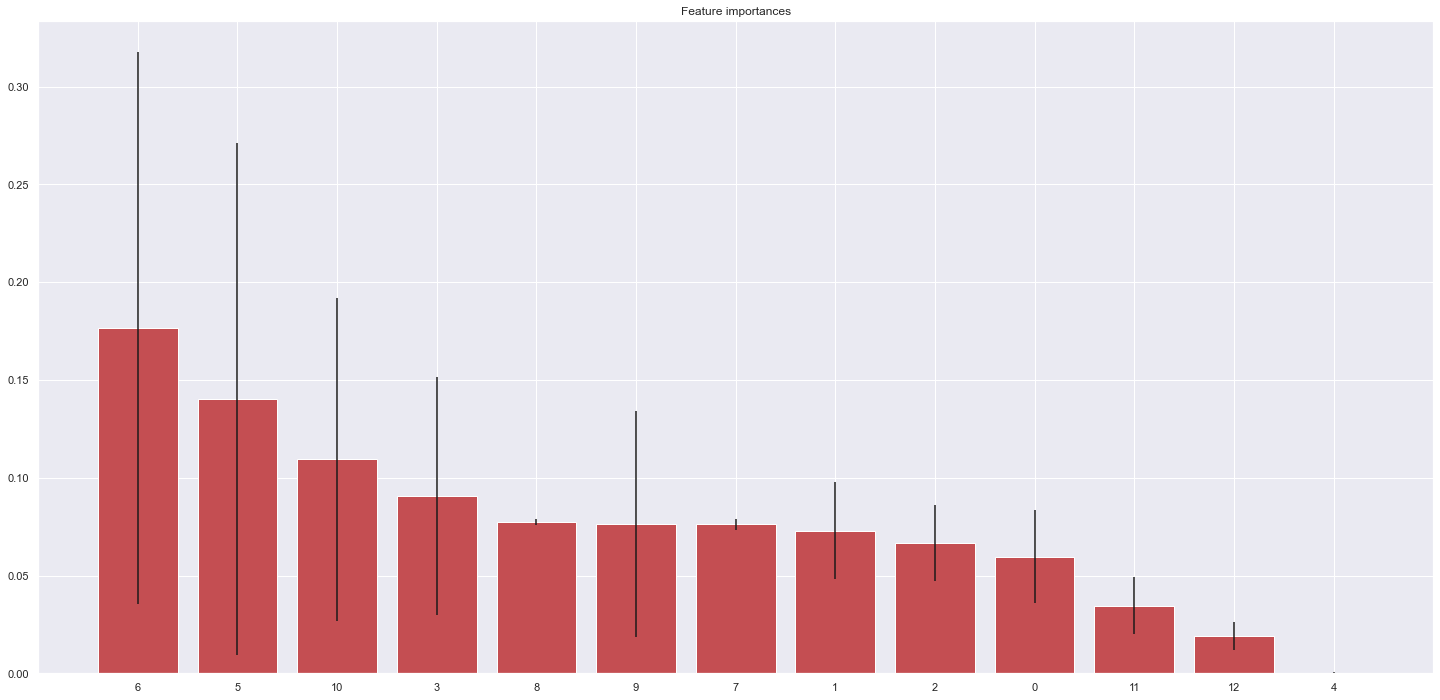

In [60]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( X_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

## 6.3 Shap

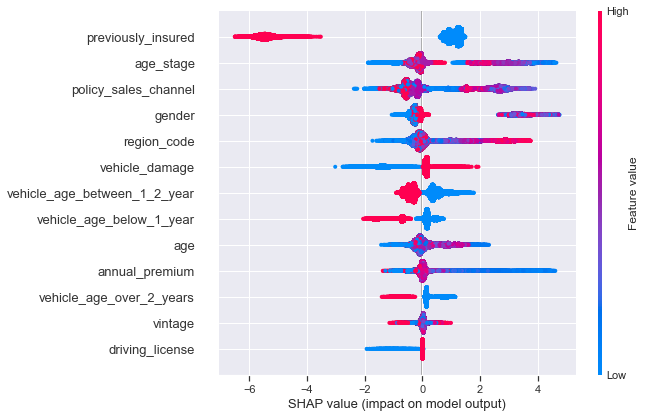

In [61]:
# model definition
# forest = ExtraTreesClassifier(random_state=0, n_jobs=-1)
xgb = XGBClassifier(n_jobs=-1,random_state=9, verbosity=0)

# data preparation
X_train_n = X_smt.drop(['id'], axis=1)
y_train_n = y_smt.values
xgb.fit(X_train_n, y_train_n)

# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_n)

shap.summary_plot(shap_values[:,:], X_train_n)

# 7.0. Machine Learning Modelling

In [62]:
#  cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
#                  'policy_sales_channel']

cols_selected = ['gender',
                 #'age',
                 'region_code',
                 'policy_sales_channel',
                 'vehicle_damage',
                 'previously_insured',
                 'annual_premium',
                 'vintage',
                 'age_stage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year']

In [63]:
# balanced
X_train_smt = X_smt[cols_selected]
y_train_smt = y_smt

# unbalanced
X_train     = X[cols_selected]
y_train     = y

X_val       = X_val[cols_selected]

## 7.1. KNN Classifier

In [64]:
# model definition
knn = KNeighborsClassifier(n_neighbors=7)

# model training
knn.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_knn = knn.predict_proba(X_val)

### 7.1.1 Model Performance

In [65]:
# Model Name
model_name = type(knn).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_knn, results_knn = ml_scores(model_name, y_val, yhat_proba_knn, top_k, k=10000)
score_knn

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,KNeighborsClassifier,38.242763,49.657186,60.868461,71.076689,86.808024,94.426105,0.309969,0.393601


### 7.1.2 Cumulative Gain & Lift Curves

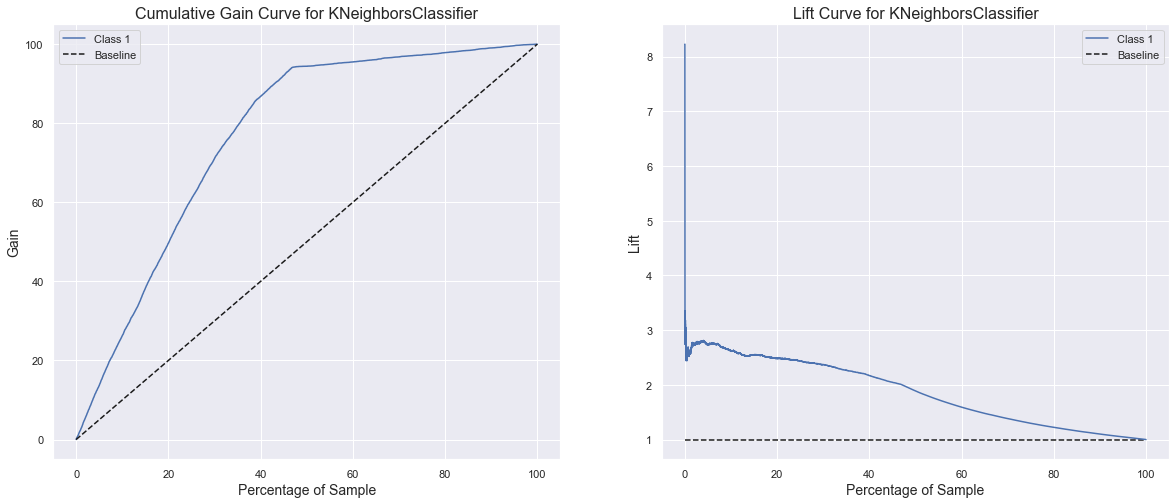

In [66]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_knn);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_knn);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

#Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_knn);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.1.3 Cros Validation

In [67]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = KNeighborsClassifier(n_neighbors=7)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_knn = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_knn

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,KNeighborsClassifier,35.4608 +/- 0.3283,46.4474 +/- 0.2396,56.8143 +/- 0.1796,66.7103 +/- 0.1687,83.845 +/- 0.2478,89.0361 +/- 0.0955,0.2895 +/- 0.0025,0.3646 +/- 0.0031


## 7.2. Logistic Regression

In [68]:
# model definition
lr = LogisticRegression(random_state=9) 

# model training
lr.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_lr = lr.predict_proba(X_val)

### 7.2.1 Model Performance

In [69]:
# Model Name
model_name = type(lr).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_lr, results_lr = ml_scores(model_name, y_val, yhat_proba_lr, top_k, k=10000)
score_lr

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,LogisticRegression,39.271204,52.044185,63.979177,74.136618,85.563738,97.10513,0.318868,0.404901


### 7.2.2 Cumulative Gain & Lift Curves

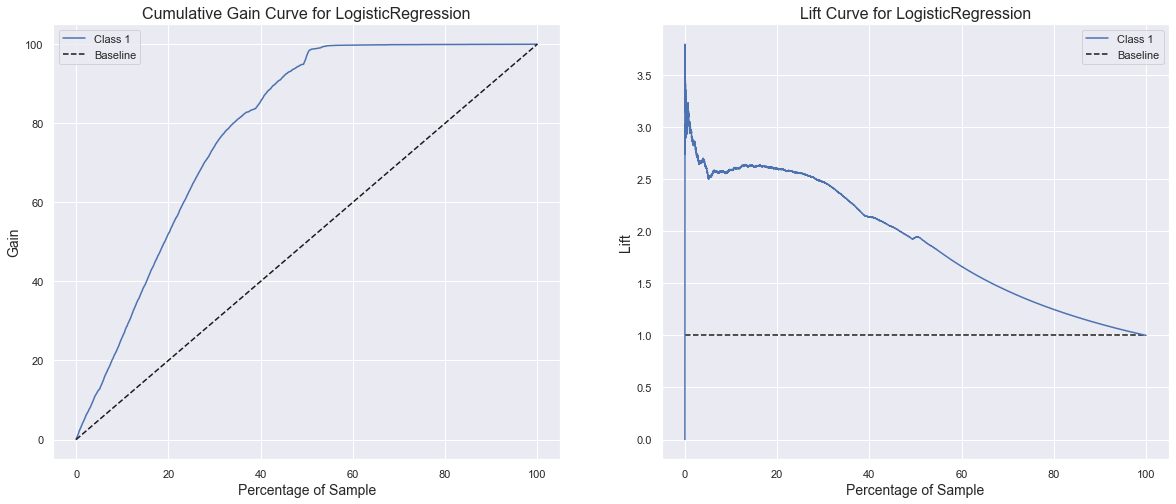

In [70]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_lr);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_lr);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_lr);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.2.3 Cros Validation

In [71]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = LogisticRegression(random_state=9)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_lr = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_lr

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,LogisticRegression,40.1128 +/- 0.2041,52.4192 +/- 0.2103,63.8768 +/- 0.2,74.4302 +/- 0.2982,89.1343 +/- 0.2164,98.6601 +/- 0.0461,0.3266 +/- 0.0017,0.4114 +/- 0.0021


## 7.3. Extra Trees Classifier

In [72]:
# model definition
et = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=9) 

# model training
et.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_et = et.predict_proba(X_val)

### 7.3.1 Model Performance

In [73]:
# Model Name
model_name = type(et).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_et, results_et = ml_scores(model_name, y_val, yhat_proba_et, top_k, k=10000)
score_et

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,ExtraTreesClassifier,38.29355,49.809548,60.347892,70.962417,86.655663,96.381412,0.310069,0.393728


### 7.3.2 Cumulative Gain & Lift Curves

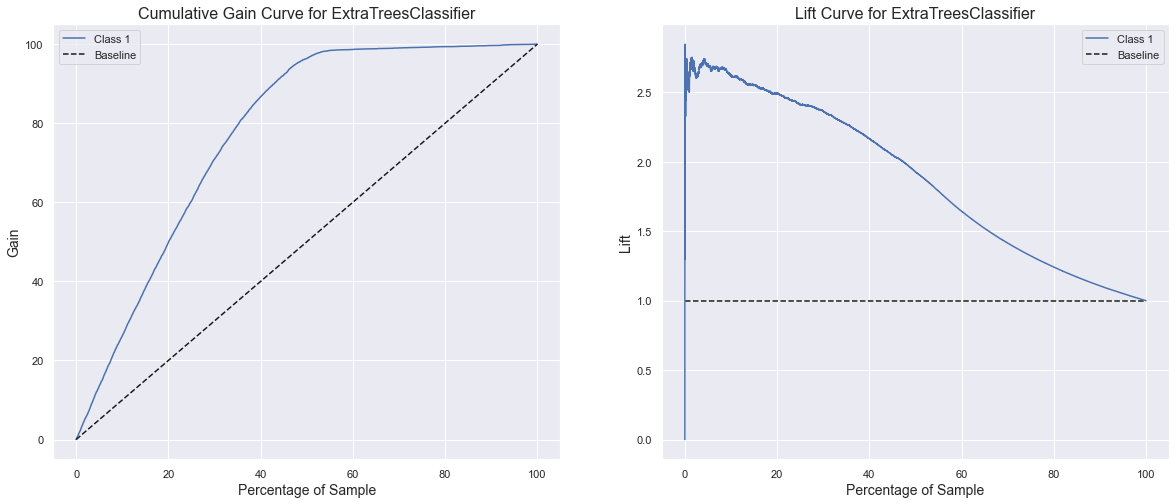

In [74]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_et);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_et);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_et);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.3.3 Cros Validation

In [75]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=9)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_et = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_et

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,ExtraTreesClassifier,38.0979 +/- 0.4925,49.3514 +/- 0.6116,59.9552 +/- 0.3309,69.7252 +/- 0.4775,86.0766 +/- 0.3585,96.5746 +/- 0.1546,0.3105 +/- 0.0044,0.391 +/- 0.0056


## 7.4. Random Forest

In [76]:
# model definition
rf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=9) 

# model training
rf.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_rf = rf.predict_proba(X_val)

### 7.4.1 Model Performance

In [77]:
# Model Name
model_name = type(rf).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_rf, results_rf = ml_scores(model_name, y_val, yhat_proba_rf, top_k, k=10000)
score_rf

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,RandomForestClassifier,39.321991,51.358558,62.150838,71.673438,87.633316,97.663789,0.318368,0.404266


### 7.4.2 Cumulative Gain & Lift Curves

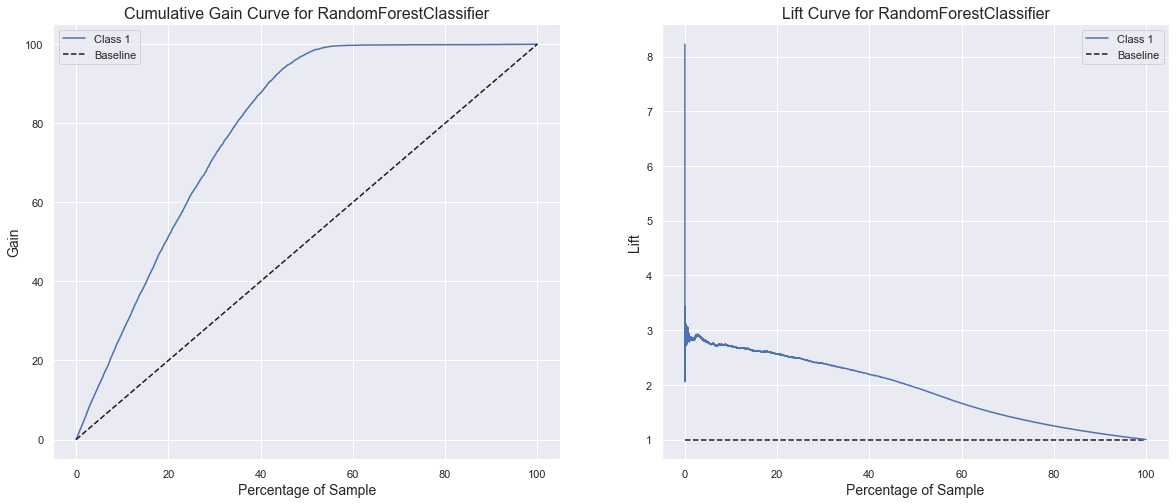

In [78]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_rf);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_rf);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_rf);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.4.3 Cros Validation

In [79]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=9)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_rf = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_rf

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,RandomForestClassifier,38.4807 +/- 0.4108,50.0265 +/- 0.4798,61.0558 +/- 0.7193,70.8662 +/- 0.6974,87.4216 +/- 0.4796,97.6324 +/- 0.1488,0.3141 +/- 0.003,0.3956 +/- 0.0038


## 7.5. XGBoost Classifier

In [80]:
# model definition
xgb = XGBClassifier(n_estimators=2000, n_jobs=-1, random_state=9, verbosity=0)

# model training
xgb.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_xgb = xgb.predict_proba(X_val)

### 7.5.1 Model Performance

In [81]:
# Model Name
model_name = type(xgb).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_xgb, results_xgb = ml_scores(model_name, y_val, yhat_proba_xgb, top_k, k=10000)
score_xgb

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,XGBClassifier,40.705942,52.386998,63.598273,73.4129,89.867953,97.981209,0.327567,0.415947


### 7.5.2 Cumulative Gain & Lift Curves

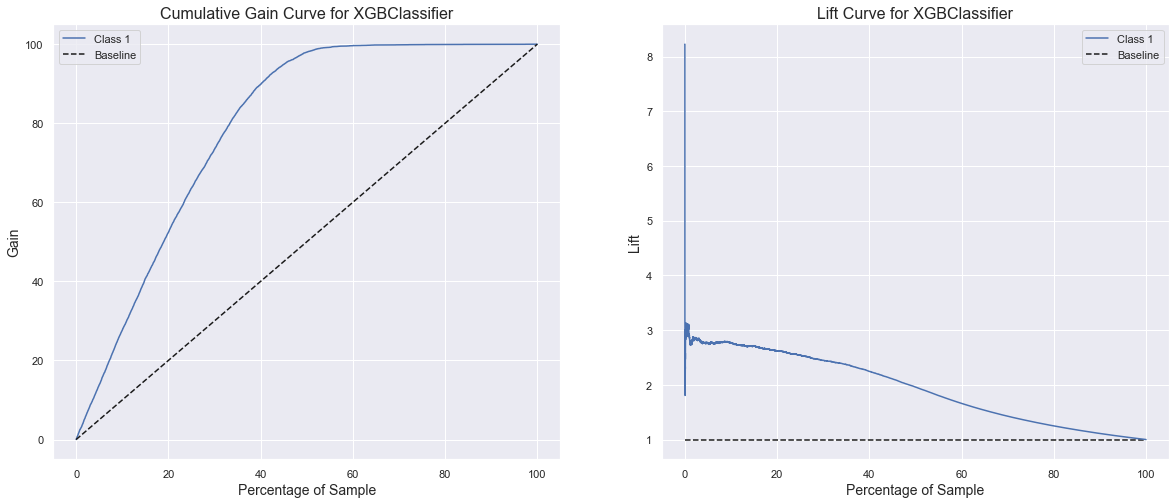

In [82]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_xgb);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_xgb);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_xgb);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.5.3 Cros Validation

In [83]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = XGBClassifier(n_estimators=2000, n_jobs=-1, random_state=9, verbosity=0)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_xgb = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,XGBClassifier,41.1707 +/- 0.1435,53.2479 +/- 0.2409,64.5921 +/- 0.209,74.7022 +/- 0.3033,90.3761 +/- 0.2453,98.3805 +/- 0.0799,0.3358 +/- 0.0012,0.423 +/- 0.0014


## 7.6 LightGBM Classifier

In [84]:
# model definition
lgbm = LGBMClassifier(n_estimators=2000, n_jobs=-1, random_state=9)

# model training
lgbm.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_lgbm = lgbm.predict_proba(X_val)

### 7.6.1 Model Performance

In [85]:
# Model Name
model_name = type(lgbm).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_lgbm, results_lgbm = ml_scores(model_name, y_val, yhat_proba_lgbm, top_k, k=10000)
score_lgbm

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,LGBMClassifier,43.384967,55.015236,66.78517,76.777552,91.708989,98.76841,0.350265,0.444769


### 7.6.2 Cumulative Gain & Lift Curves

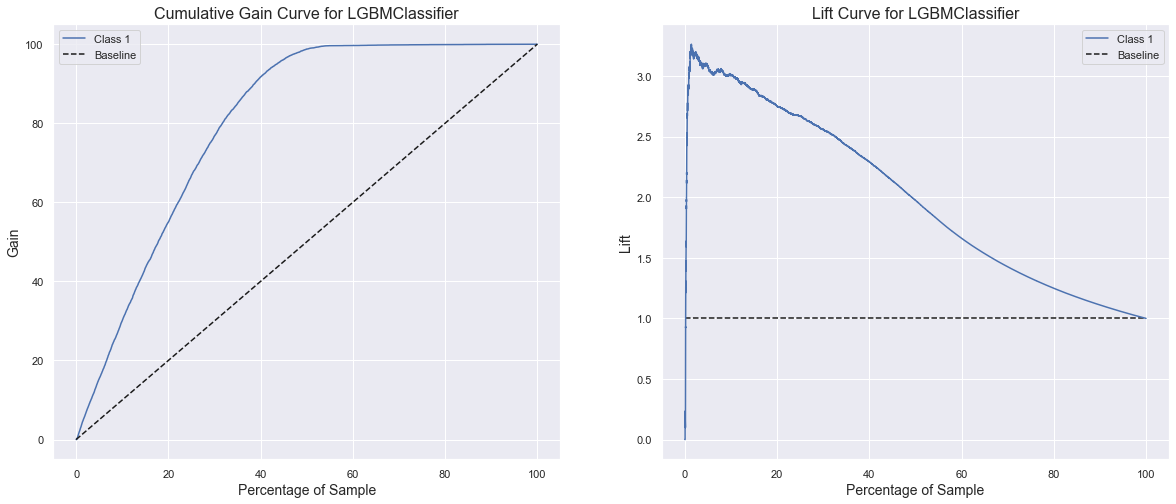

In [86]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_lgbm);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_lgbm);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_lgbm);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.6.3 Cros Validation

In [88]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = LGBMClassifier(n_estimators=2000, n_jobs=-1, random_state=9)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_lgbm = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,LGBMClassifier,42.6416 +/- 0.4649,55.1545 +/- 0.5084,66.262 +/- 0.6288,76.3721 +/- 0.4941,91.3331 +/- 0.302,98.6147 +/- 0.1563,0.3477 +/- 0.0038,0.4379 +/- 0.0048


## 7.7 Catboost Classifier

In [89]:
# model definition
cat = CatBoostClassifier(random_state=9, verbose=False)

# model training
cat.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_cat = cat.predict_proba(X_val)

### 7.7.1 Model Performance

In [90]:
# Model Name
model_name = type(cat).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_cat, results_cat = ml_scores(model_name, y_val, yhat_proba_cat, top_k, k=10000)
score_cat

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,CatBoostClassifier,43.791265,56.259523,67.280345,77.22194,92.166074,98.76841,0.354865,0.450609


### 7.7.2 Cumulative Gain & Lift Curves

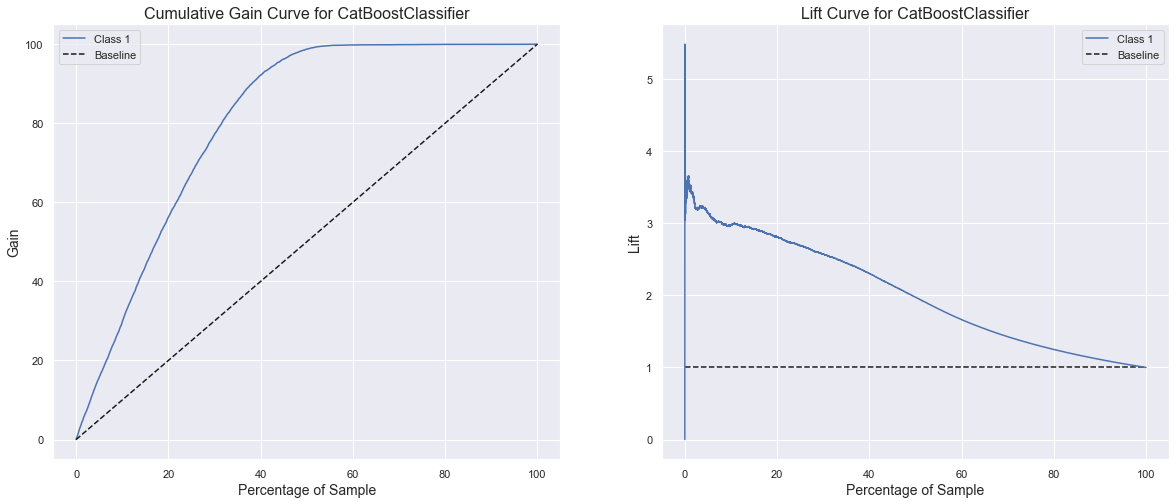

In [91]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_cat);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_cat);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_cat);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

### 7.7.3 Cros Validation

In [92]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = CatBoostClassifier(random_state=9, verbose=False)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_cat = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_cat

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,CatBoostClassifier,42.4502 +/- 0.411,54.8145 +/- 0.5465,66.3149 +/- 0.4456,76.5358 +/- 0.3413,91.5926 +/- 0.2149,98.7986 +/- 0.0771,0.3462 +/- 0.0034,0.436 +/- 0.0043


## 7.8 Models Compare

In [93]:
df_compare = pd.concat([result_knn, result_lr, result_et, result_rf, result_xgb, result_lgbm, result_cat], axis=0).reset_index(drop=True)
df_compare

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,KNeighborsClassifier,35.4608 +/- 0.3283,46.4474 +/- 0.2396,56.8143 +/- 0.1796,66.7103 +/- 0.1687,83.845 +/- 0.2478,89.0361 +/- 0.0955,0.2895 +/- 0.0025,0.3646 +/- 0.0031
1,LogisticRegression,40.1128 +/- 0.2041,52.4192 +/- 0.2103,63.8768 +/- 0.2,74.4302 +/- 0.2982,89.1343 +/- 0.2164,98.6601 +/- 0.0461,0.3266 +/- 0.0017,0.4114 +/- 0.0021
2,ExtraTreesClassifier,38.0979 +/- 0.4925,49.3514 +/- 0.6116,59.9552 +/- 0.3309,69.7252 +/- 0.4775,86.0766 +/- 0.3585,96.5746 +/- 0.1546,0.3105 +/- 0.0044,0.391 +/- 0.0056
3,RandomForestClassifier,38.4807 +/- 0.4108,50.0265 +/- 0.4798,61.0558 +/- 0.7193,70.8662 +/- 0.6974,87.4216 +/- 0.4796,97.6324 +/- 0.1488,0.3141 +/- 0.003,0.3956 +/- 0.0038
4,XGBClassifier,41.1707 +/- 0.1435,53.2479 +/- 0.2409,64.5921 +/- 0.209,74.7022 +/- 0.3033,90.3761 +/- 0.2453,98.3805 +/- 0.0799,0.3358 +/- 0.0012,0.423 +/- 0.0014
5,LGBMClassifier,42.6416 +/- 0.4649,55.1545 +/- 0.5084,66.262 +/- 0.6288,76.3721 +/- 0.4941,91.3331 +/- 0.302,98.6147 +/- 0.1563,0.3477 +/- 0.0038,0.4379 +/- 0.0048
6,CatBoostClassifier,42.4502 +/- 0.411,54.8145 +/- 0.5465,66.3149 +/- 0.4456,76.5358 +/- 0.3413,91.5926 +/- 0.2149,98.7986 +/- 0.0771,0.3462 +/- 0.0034,0.436 +/- 0.0043


# 8.0 Hyperparameter Fine Tuning

- CatBoost

In [94]:
def tune_cat(params):
    print(params)
    iterations          = params[0]
    learning_rate       = params[1]
    depth               = params[2]
    min_child_samples   = params[3]
    random_strength     = params[4]
    bagging_temperature = params[5]
    border_count        = params[6]
    scale_pos_weight    = params[7]
        
    # Model
    model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, min_child_samples=min_child_samples,
                                random_strength=random_strength, bagging_temperature=bagging_temperature, border_count=border_count,
                                scale_pos_weight=scale_pos_weight,
                                thread_count=2, loss_function='Logloss', random_state=9, verbose=False)
    
    
    model.fit(X_train_smt, y_train_smt)

    # Model Name
    model_name = type(model).__name__

    # Prediction Proba
    yhat_proba = model.predict_proba(X_val)
    # Performance
    top_k = 0.2
    results, _ = ml_scores(model_name, y_val, yhat_proba, top_k, k=10000)
              
    
    return -float(results['accuracy_top_20.0%']/100)


space = [(100, 1500), # iterations
        (5e-3, 1e-1, 'log-uniform'), # learning_rate
        (1, 15), # depth
        (1, 15), # min_child_samples
        #(1, 20), # max_leaves
        #(0.05, 1.0), # colsample_bytree
        (1e-9, 10), # random_strength
        (0.0, 1.0), # bagging_temperature
        (1, 255), # border_count
        (0.01, 1.0)] # scale_pos_weight   
         
         
result = forest_minimize(tune_cat, space, random_state=9, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[448, 0.02248660560297912, 7, 9, 1.3382952904589365, 0.14211108545453857, 23, 0.878448995384001]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 41.6025
Function value obtained: -0.5466
Current minimum: -0.5466
Iteration No: 2 started. Evaluating function at random point.
[1420, 0.010513735969016178, 9, 6, 3.454986401158503, 0.16677634653232146, 129, 0.3802116695899843]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 143.1601
Function value obtained: -0.5555
Current minimum: -0.5555
Iteration No: 3 started. Evaluating function at random point.
[1311, 0.0056154272294418935, 9, 14, 5.727598156121334, 0.8980071182251498, 13, 0.9512990866777258]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 124.2233
Function value obtained: -0.5443
Current minimum: -0.5555
Iteration No: 4 started. Evaluating function at random point.
[229, 0.08438020590773604, 12, 6, 5.648697080516121

In [95]:
result_cat = result.x
result_cat

[890,
 0.07993067333618473,
 5,
 6,
 6.696306112971143,
 0.5817513903483812,
 75,
 0.9072145041542727]

In [96]:
# [1420, 0.010513735969016178, 9, 6, 3.454986401158503, 0.16677634653232146, 129, 0.3802116695899843]

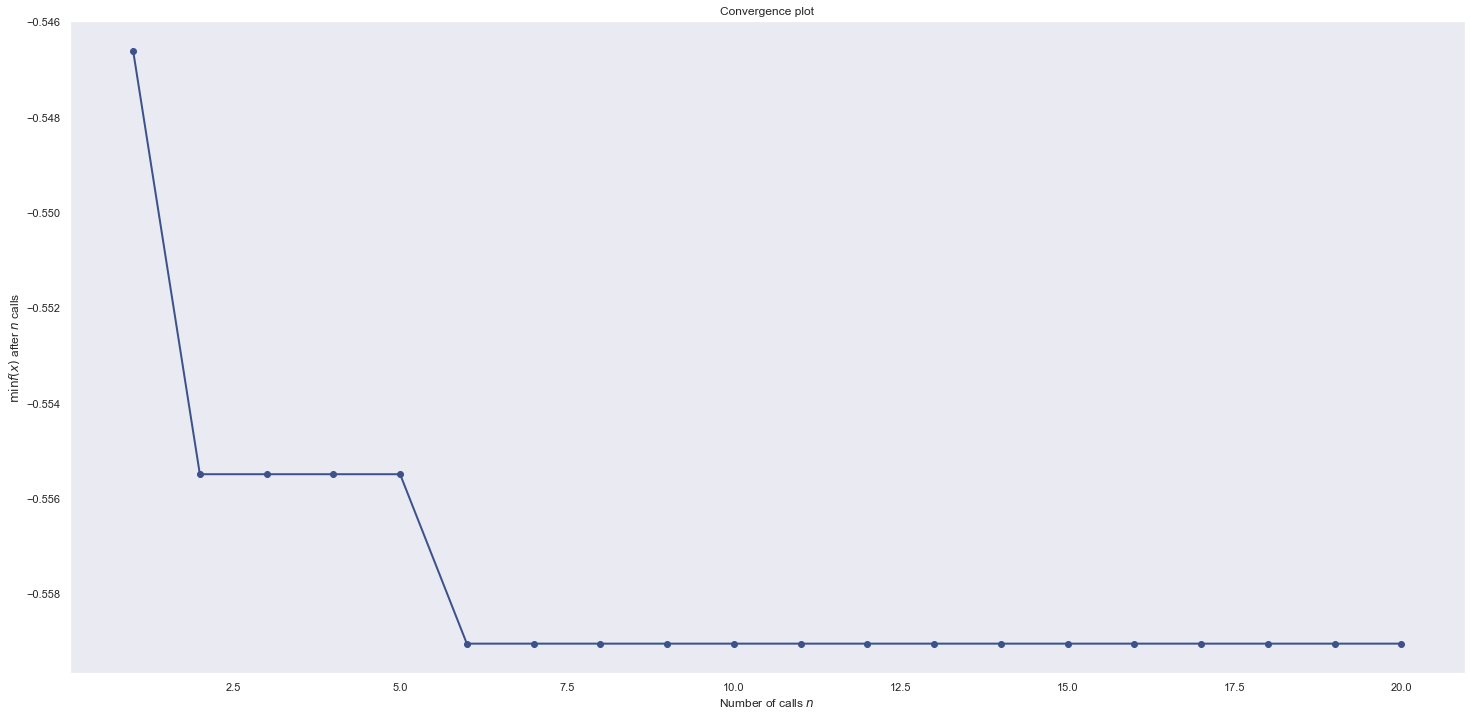

In [97]:
plot_convergence(result);

# 9.0 Final Model

In [98]:
params_cat = result_cat

#params_cat = [1420, 0.010513735969016178, 9, 6, 3.454986401158503, 0.16677634653232146, 129, 0.3802116695899843]

iterations          = params_cat[0]
learning_rate       = params_cat[1]
depth               = params_cat[2]
min_child_samples   = params_cat[3]
random_strength     = params_cat[4]
bagging_temperature = params_cat[5]
border_count        = params_cat[6]
scale_pos_weight    = params_cat[7]

#Model
cat_tuned = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, min_child_samples=min_child_samples,
                            random_strength=random_strength, bagging_temperature=bagging_temperature, border_count=border_count,
                            scale_pos_weight=scale_pos_weight,
                            thread_count=2, loss_function='Logloss', random_state=9, verbose=False)


cat_tuned.fit(X_train_smt, y_train_smt)

# model prediction
yhat_proba_cat_tuned = cat_tuned.predict_proba(X_val)

## 9.1 Model Performance

In [99]:
# Model Name
model_name = type(cat_tuned).__name__

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

score_cat_tuned, results_cat_tuned = ml_scores(model_name, y_val, yhat_proba_cat_tuned, top_k, k=10000)
score_cat_tuned

,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,CatBoostClassifier,43.511935,55.904012,66.848654,77.437786,92.127984,98.743017,0.351165,0.445912


## 9.2 Cumulative Gain & Lift Curves

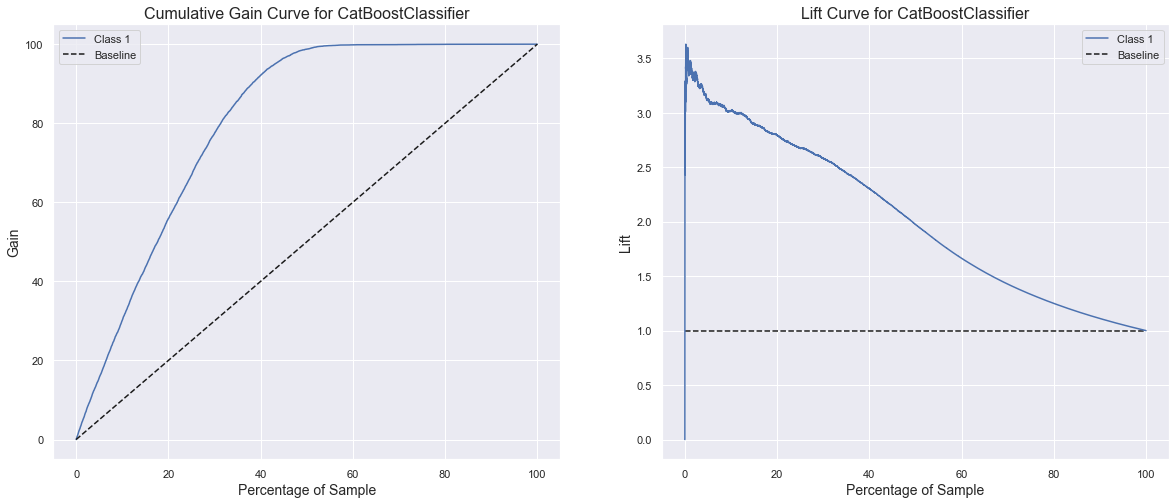

In [100]:
plt.figure(figsize=(20,8))

# Accumulative Gain
plt.subplot(1, 2, 1)
sns.lineplot(x='base_cum_perc', y='real_cum_perc', label='Class 1', data=results_cat_tuned);
sns.lineplot(x='base_cum_perc', y='baseline', color='k', linestyle='--', label='Baseline', data=results_cat_tuned);
plt.title(f'Cumulative Gain Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Gain', fontsize=14);
plt.legend();

# Lift
plt.subplot(1, 2, 2)
sns.lineplot(x='base_cum_perc', y='lift', label='Class 1', data=results_cat_tuned);
plt.hlines(1.0, 0.0, 100.0, colors='k', label='Baseline', linestyles='--');
plt.title(f'Lift Curve for {model_name}', fontsize=16);
plt.xlabel('Percentage of Sample', fontsize=14);
plt.ylabel('Lift', fontsize=14);
plt.legend();

## 9.3 Cros Validation

In [101]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_val], axis = 0)
X_train_cv = pd.concat([X_train, X_val], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, min_child_samples=min_child_samples,
                            random_strength=random_strength, bagging_temperature=bagging_temperature, border_count=border_count,
                            scale_pos_weight=scale_pos_weight,
                            thread_count=2, loss_function='Logloss', random_state=9, verbose=False)

top_k = [0.15, 0.2, 0.25, 0.30, 0.4, 0.5]

result_cat_tuned = cross_validation(X_train_cv, y_train_cv, model, top_k, k=10000, num_folds=5, is_unbalance=True, verbose=True)
result_cat_tuned

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,model_name,accuracy_top_15.0%,accuracy_top_20.0%,accuracy_top_25.0%,accuracy_top_30.0%,accuracy_top_40.0%,accuracy_top_50.0%,precision_at_k,recall_at_k
0,CatBoostClassifier,41.4528 +/- 0.5098,53.7113 +/- 0.5637,65.3276 +/- 0.3378,75.5736 +/- 0.3776,91.3609 +/- 0.2005,98.8036 +/- 0.0797,0.338 +/- 0.0043,0.4257 +/- 0.0054
